# Introduction


Allstate is an American insurance company (Ticker: NYSE: ALL) with much of its business in the auto insurance space. With several million policyholders at any given time, Allstate generates a tremendous amount of data and in particular, claims data. In order to maintain financial strength as an insurer and as a competitive business, it must be able to accurately forecast its revenues and expenses. A large portion of any insurer's expenses is the cost of claims and so finding the best models to predict individual claim amounts has a large impact on their budgeting, investing, expansion, and most of all, profits.

It is no surprise that today, perhaps more than ever, bringing in staff with strong data analysis skills including statistics, machine learning, and domain expertise is a key factor in developing its insurance products and differentiating the company in the marketplace. Advancements in modelling have only a few years at most to deliver unnoticed results before the methods are arbitraged away as competitors perform their own internal research and monitor industry trends.

In an effort to attract talent, Allstate hosted a Kaggle competition to predict auto claims loss severity using a large dataset.

As this competition ended several years ago, this project is for educational purposes.

The goal is to compare the performances of several linear models against a gradient boosting regressor over the Allstate claims loss severity dataset and achieve the lowest mean absolute error.

Along the way we will discuss some aspects of the data and our modelling to provide context for our decisions. 

The competition, dataset, leaderboards, and discussions may be found here: https://www.kaggle.com/c/allstate-claims-severity/overview  


## Importing Tools


To begin this analysis, we will first import two groups of packages. The first group is what we call the essentials - pandas, numpy, matplotlib, and seaborn to manipulate data and visualize relationships.

The second group is our modelling tools for this particular analysis. 
We start with a vanilla linear regression model and gradually add complexity, resulting in an elastic net model which is cross-validated. Along the way we also look at an implemeentation of a generalized linear model, gamma regoressor,  a common technique previously used in claims severity prediction until newer methods such as gradient boosting machines demonstrated superior performance.

To evaluate the models we examine their mean absolute errors, as per the competition specifications, as well as their R^2 scores, and mean squared errors. 

The modelling process will have two stages. The first stage will be considering numerical variables only while the second stage will consider all variables. 

In [1]:
# Importing Packages

#The essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Import modelling tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.linear_model import GammaRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE

Upon downloading and inspecting the datas in Excel, we that it carries a column labeled as 'id'. When importing the data, we will specify that there is an index column, saving a small bit of work down the line.

In [2]:
#Load it up!
filepath = "all_state_claim_severity_train.csv" 
df = pd.read_csv(filepath, index_col = 'id')

## Inspecting the Data

Now that our data is loaded, we are ready to begin the analysis. We will first inspect the data to understand its size and shape, structure of columns, and basic descriptive statistics.

Here we observe that there are 131 total columns, 116 are categorgical variables of type 'object', typically strings. We will transform these columns later on so that we can model with them. There are also 15 columns of type 'float64', one is our target variable, 'loss', the others are 14 numerical features. The dataset labels categorical variables as cat and numerical features as cont, from here on out, we will refer to them as such.

With 188,318 observations, we have plenty of data to conduct our analysis.

Checking for NAs by summing over null values, we see that there are no missing data points and so we do not have to make determinations on imputation methods or dropping rows of our data (which *might* not be so problematic given the large size). 

Our descriptive statistics reveal that all of our continuous features lie between 0 and 1 which is good to know.

Lastly, we separate the categorical and continuous features so that the data is prepared for visualizations and modelling. 

In [3]:
#Inspecting the data set
df_columns = df.columns
print(df_columns)
print(df.dtypes)
print(df.info())
print("Number of null/NA values: ", df.isnull().values.sum())
print(df.head())
print(df.describe())

#To be used for Linear Models
df_cat = df.iloc[:, :116] 
df_cont = df.iloc[:, 116:] 

Index(['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9',
       'cat10',
       ...
       'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12',
       'cont13', 'cont14', 'loss'],
      dtype='object', length=131)
cat1       object
cat2       object
cat3       object
cat4       object
cat5       object
           ...   
cont11    float64
cont12    float64
cont13    float64
cont14    float64
loss      float64
Length: 131, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 188318 entries, 1 to 587633
Columns: 131 entries, cat1 to loss
dtypes: float64(15), object(116)
memory usage: 189.7+ MB
None
Number of null/NA values:  0
   cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9 cat10  ...     cont6  \
id                                                     ...             
1     A    B    A    B    A    A    A    A    B     A  ...  0.718367   
2     A    B    A    A    A    A    A    A    B     B  ...  0.438917   
5     A    B    A    A    B    A  

With 116 categorical variables, we should take a look at unique values to see more detail before transforming them later.

Most of these features are binary, and they increase up to the largest, 'cat116', with 326 possible values. 
'cat112' has 51 unique values. Since Allstate is an American insurance company, it is possible these values are the 50 states plus the District of Columbia.

In [4]:
#Checking out the unique values in each category
unique_cats = {col: df_cat[col].nunique() for col in df_cat.columns}
print(unique_cats)

{'cat1': 2, 'cat2': 2, 'cat3': 2, 'cat4': 2, 'cat5': 2, 'cat6': 2, 'cat7': 2, 'cat8': 2, 'cat9': 2, 'cat10': 2, 'cat11': 2, 'cat12': 2, 'cat13': 2, 'cat14': 2, 'cat15': 2, 'cat16': 2, 'cat17': 2, 'cat18': 2, 'cat19': 2, 'cat20': 2, 'cat21': 2, 'cat22': 2, 'cat23': 2, 'cat24': 2, 'cat25': 2, 'cat26': 2, 'cat27': 2, 'cat28': 2, 'cat29': 2, 'cat30': 2, 'cat31': 2, 'cat32': 2, 'cat33': 2, 'cat34': 2, 'cat35': 2, 'cat36': 2, 'cat37': 2, 'cat38': 2, 'cat39': 2, 'cat40': 2, 'cat41': 2, 'cat42': 2, 'cat43': 2, 'cat44': 2, 'cat45': 2, 'cat46': 2, 'cat47': 2, 'cat48': 2, 'cat49': 2, 'cat50': 2, 'cat51': 2, 'cat52': 2, 'cat53': 2, 'cat54': 2, 'cat55': 2, 'cat56': 2, 'cat57': 2, 'cat58': 2, 'cat59': 2, 'cat60': 2, 'cat61': 2, 'cat62': 2, 'cat63': 2, 'cat64': 2, 'cat65': 2, 'cat66': 2, 'cat67': 2, 'cat68': 2, 'cat69': 2, 'cat70': 2, 'cat71': 2, 'cat72': 2, 'cat73': 3, 'cat74': 3, 'cat75': 3, 'cat76': 3, 'cat77': 4, 'cat78': 4, 'cat79': 4, 'cat80': 4, 'cat81': 4, 'cat82': 4, 'cat83': 4, 'cat84': 4, 

The last things to check before moving on are the skewness and kurtosis of the continuous features.

Looking at the skew, only the 'loss' column stands out. The same is true for the kurtosis. Immediately we understand that the distribution of losses is not normal. According to the Casualty Acturial Society text, Generalized Linear Models for Insurance Rating (Goldburd, Khare, et al), claims severities are typically gamma distributed. With this in mind, we can now begin exploring the data visually.

In [5]:
#Checking out skew and kurtosis
skew = df.skew()
print("Skew of our data \n", skew)
kurtosis = df.kurtosis()
print("Kurtosis of our data \n", kurtosis)

Skew of our data 
 cont1     0.516424
cont2    -0.310941
cont3    -0.010002
cont4     0.416096
cont5     0.681622
cont6     0.461214
cont7     0.826053
cont8     0.676634
cont9     1.072429
cont10    0.355001
cont11    0.280821
cont12    0.291992
cont13    0.380742
cont14    0.248674
loss      3.794958
dtype: float64
Kurtosis of our data 
 cont1     -0.101712
cont2     -0.895657
cont3     -0.606562
cont4     -0.965424
cont5     -0.876877
cont6     -0.760544
cont7      0.050145
cont8     -0.542127
cont9      0.563925
cont10    -0.851664
cont11    -1.050055
cont12    -1.028374
cont13    -1.349334
cont14    -1.530071
loss      48.079568
dtype: float64


## Exploratory Data Analysis

Now that we have some idea of the structure of this dataset, we can begin looking at features and some of their relationships.

Here we plot two histograms, one of 'loss' and the other of the logarithm of 'loss'.
Right away it is clear that 'loss' is indeed a gamma distributed variable and the log of 'loss' is roughly normal with a mean around 7.5 or so. 

Why would, or should, the loss severity of claims be distributed as such? Well, to put it simply, many auto insurance policies do not file any claims, hence the first spike at 0, and most auto insurance policies never experience a large claim. Here we see that very few claims pass the 20,000 mark. Many claims are small accidents with minor damage to autos or injury to persons. 

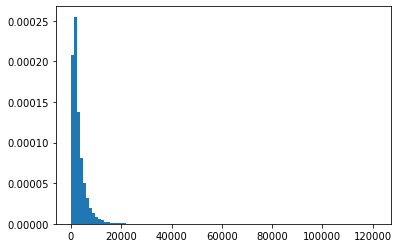

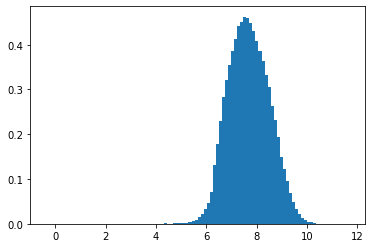

In fact, the mean of log 'loss' is  7.6852678428493535 . Not a bad guess!


In [6]:
#Checking out the distribution of the target variable, 'loss'
plt.hist(df.loss, density = True, bins = 100)
plt.show()

log_loss = np.log(df.loss)
plt.hist(log_loss, density = True, bins = 100)
plt.show()

print("In fact, the mean of log 'loss' is ", np.mean(np.log(df['loss'])), ". Not a bad guess!")


Looking at countplots, most of the binary features favor one value, while just a few are well-balanced. As for the high cardinality features, they are more balanced, with a few having just one or two values with the majority of counts. 

<ipython-input-7-61aaea5824d3>:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fg, ax = plt.subplots(nrows = 1, ncols = n_cols, sharey = True, figsize = (12, 8))


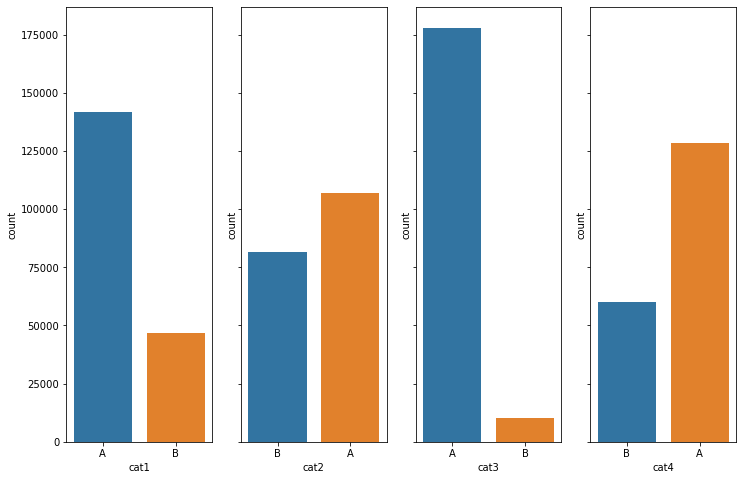

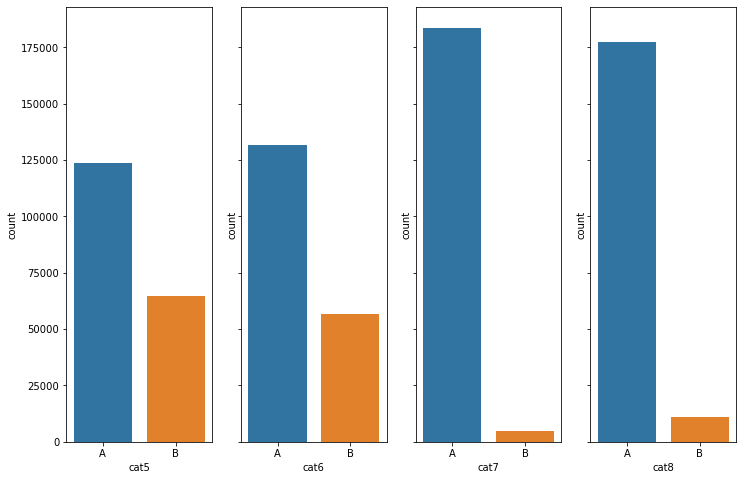

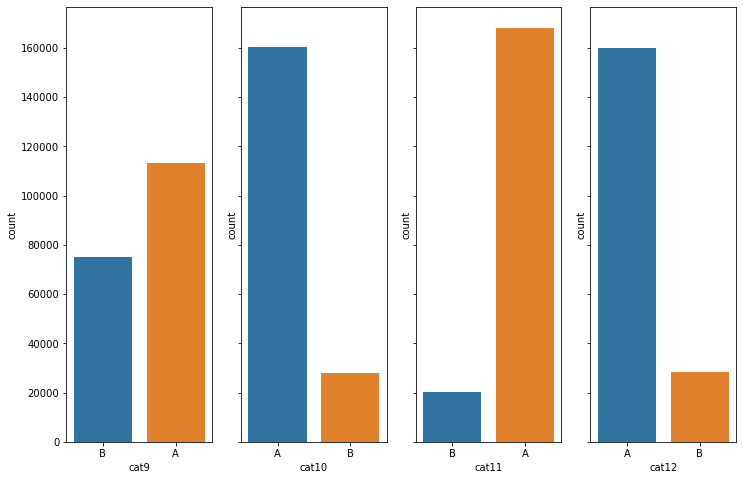

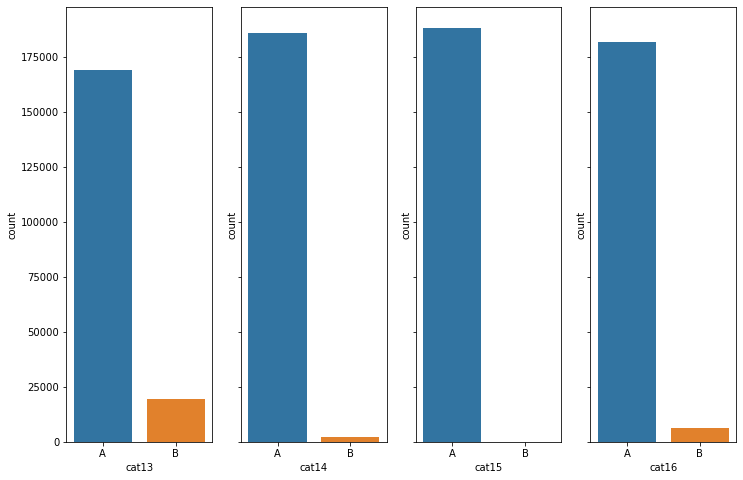

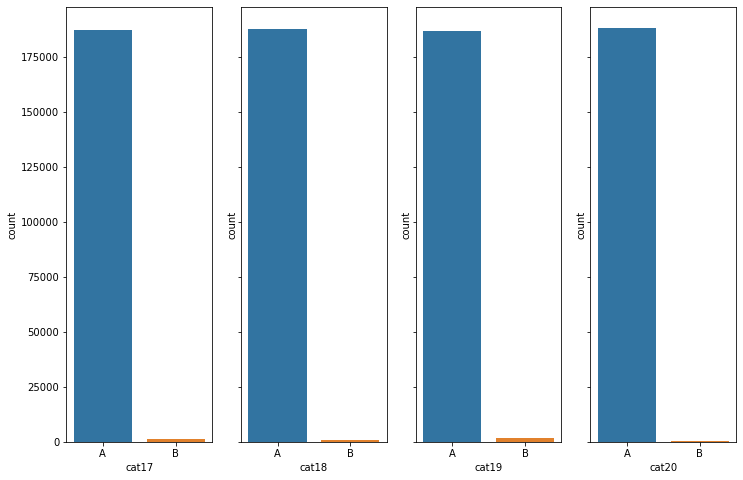

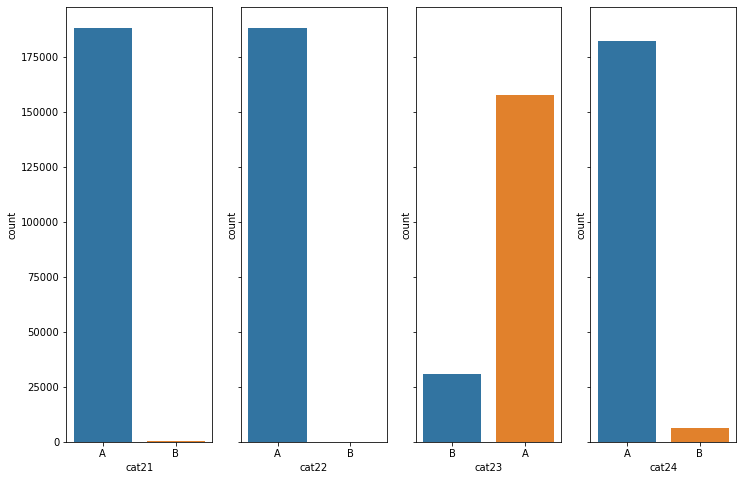

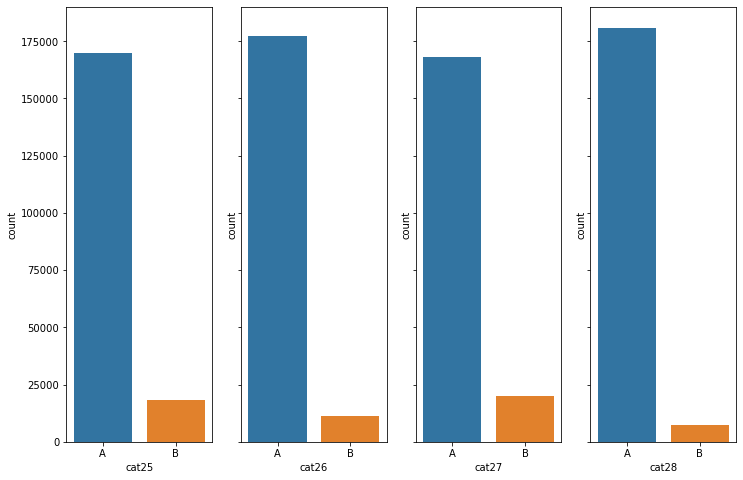

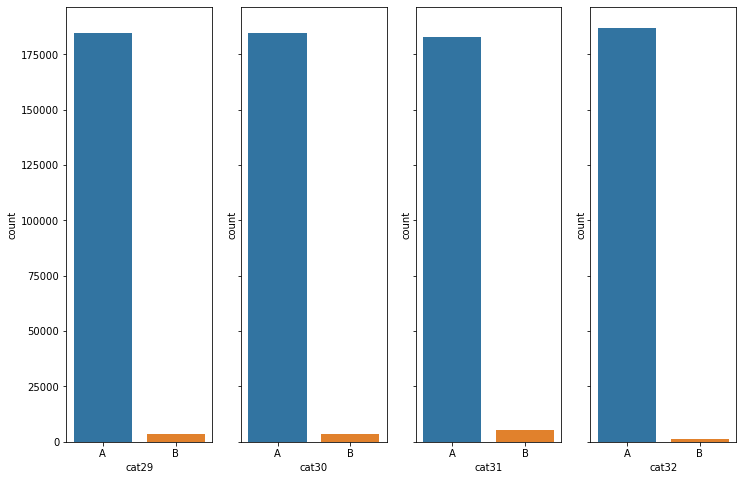

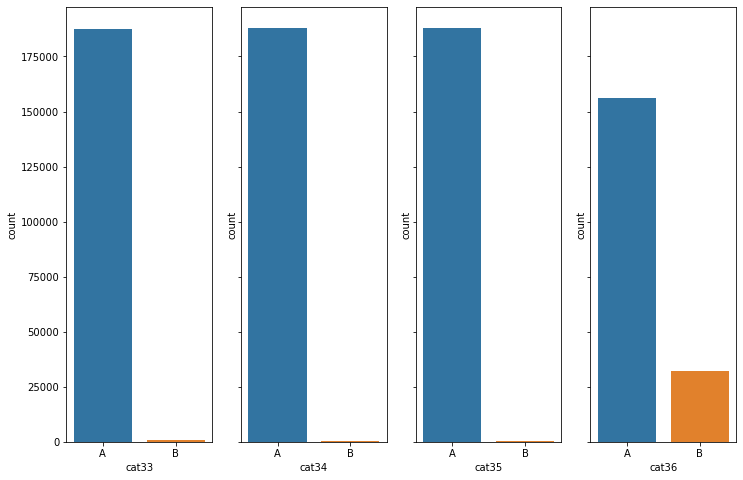

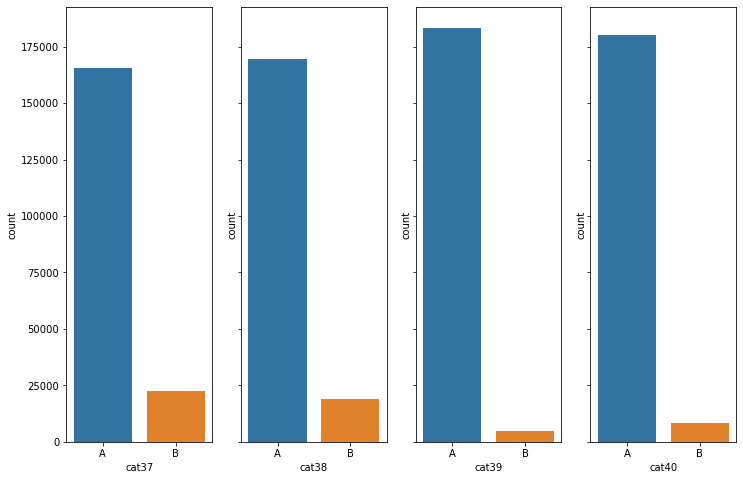

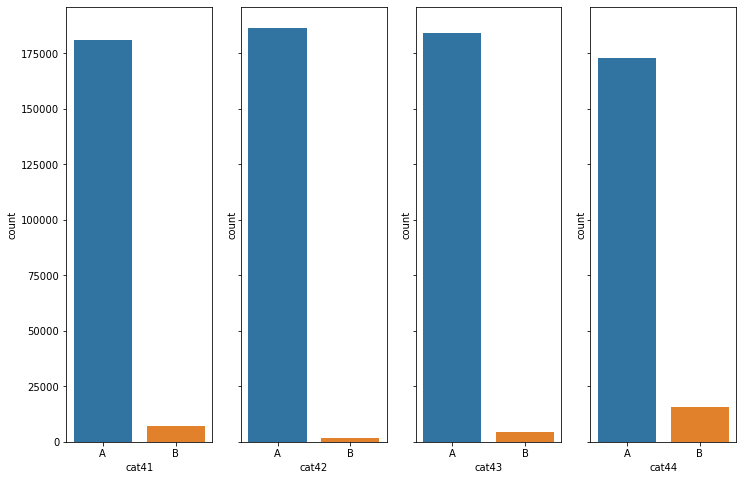

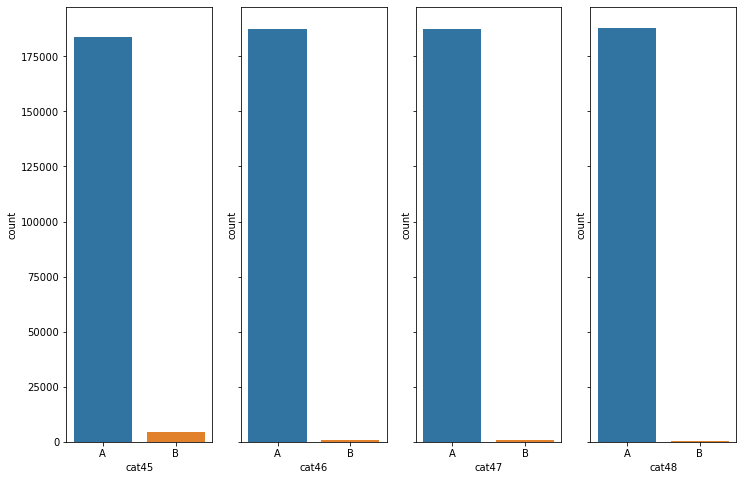

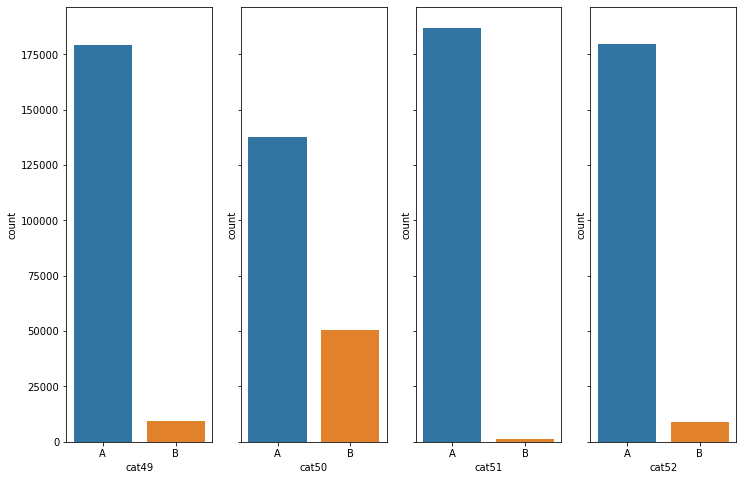

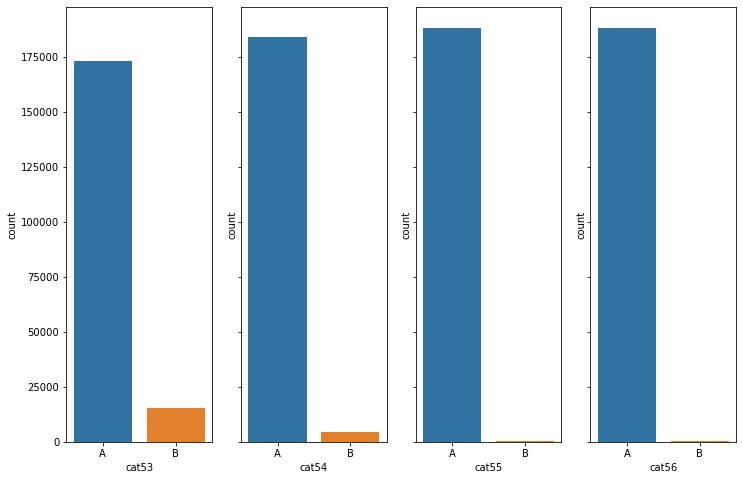

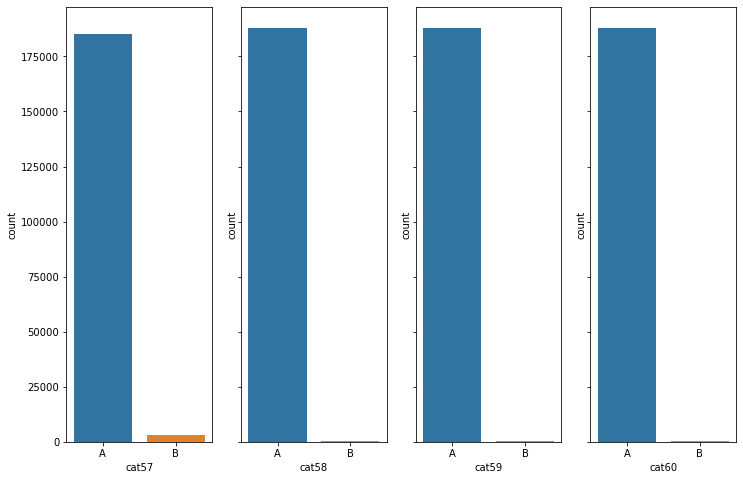

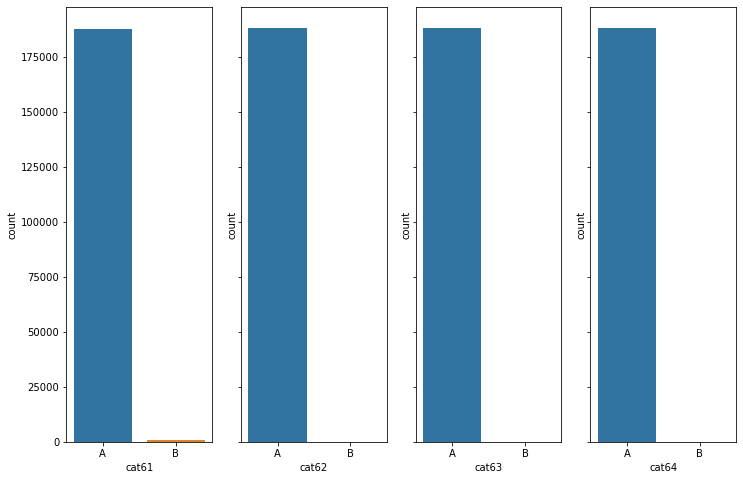

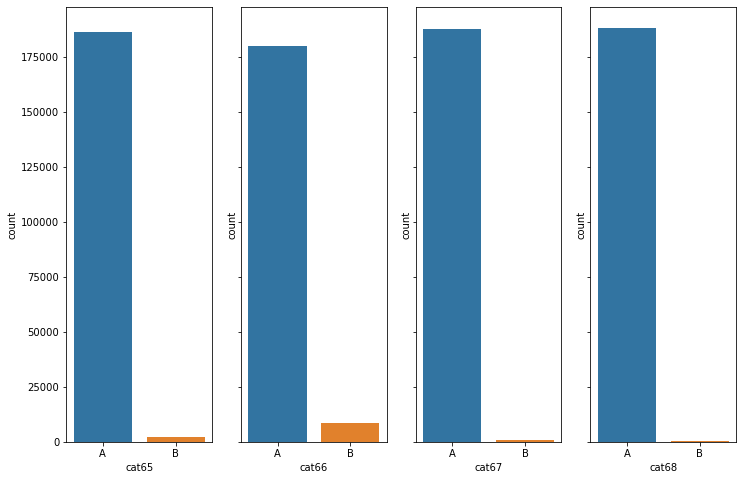

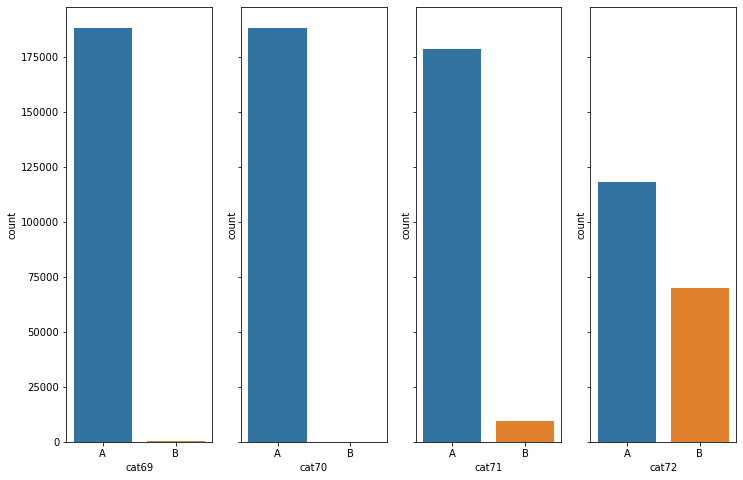

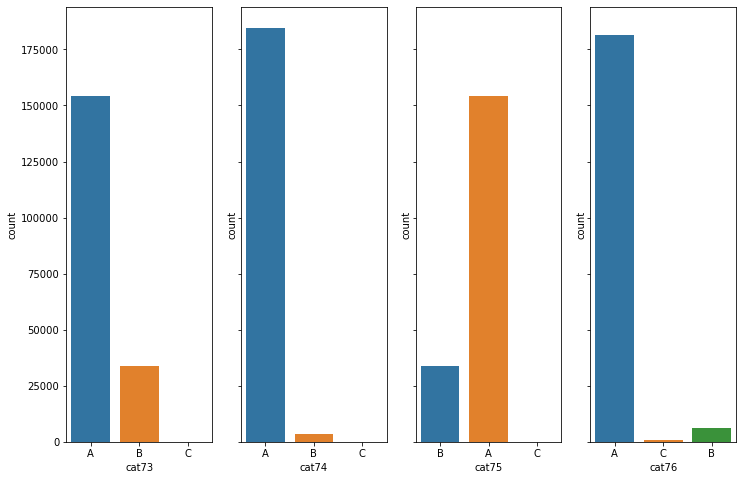

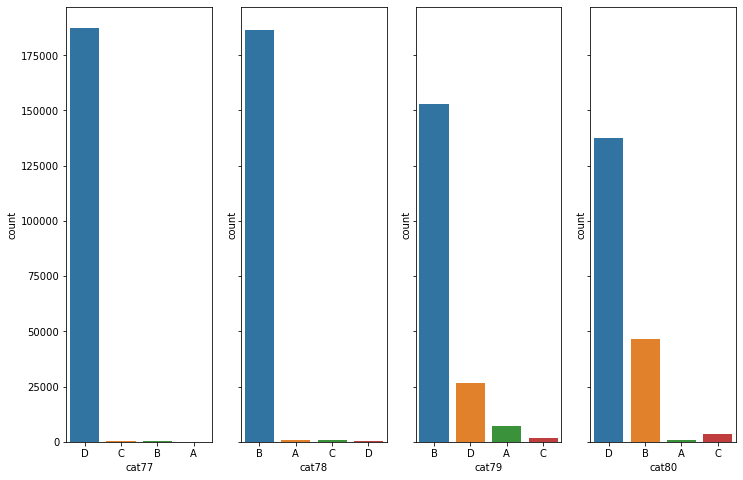

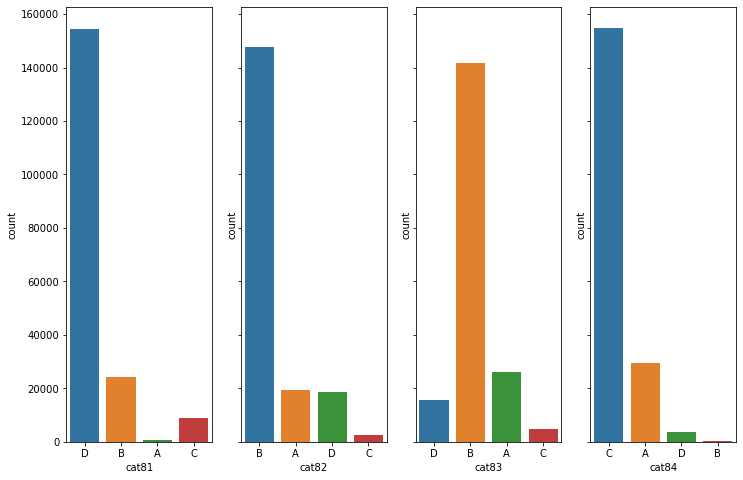

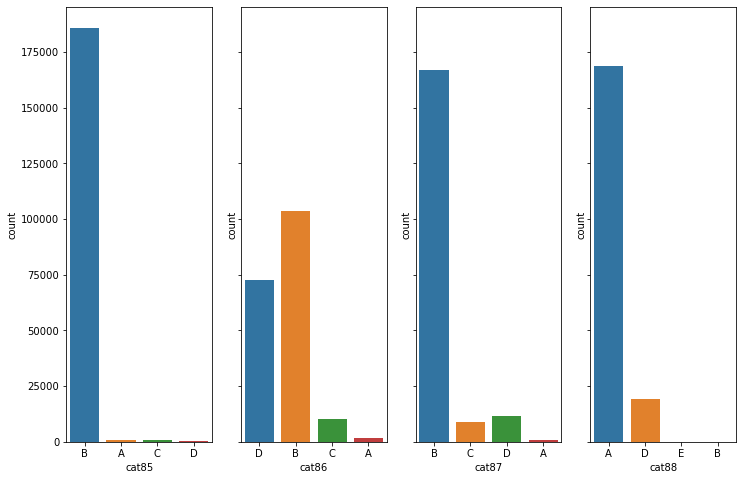

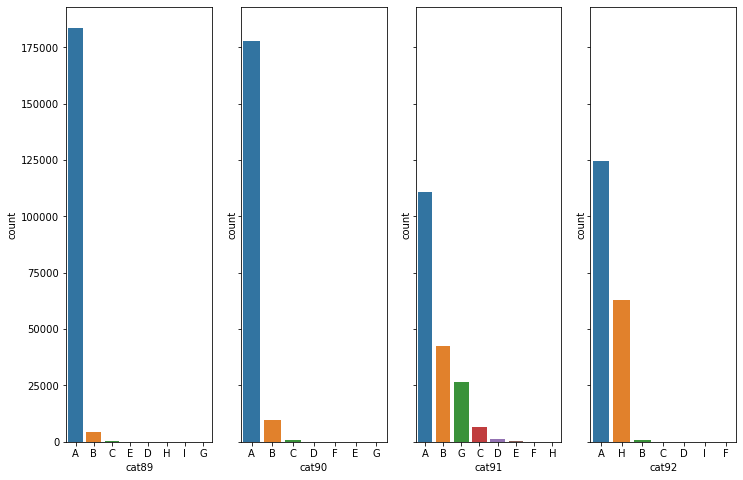

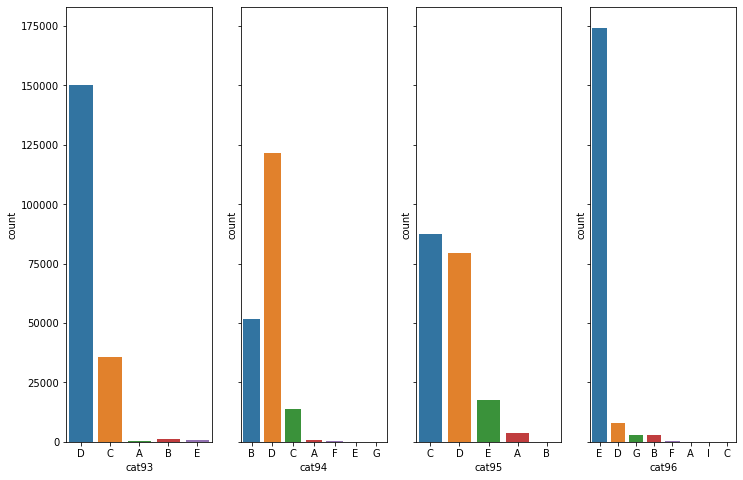

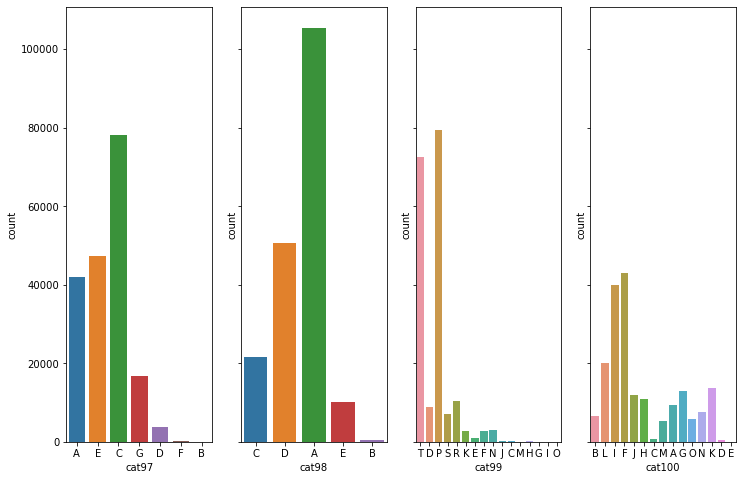

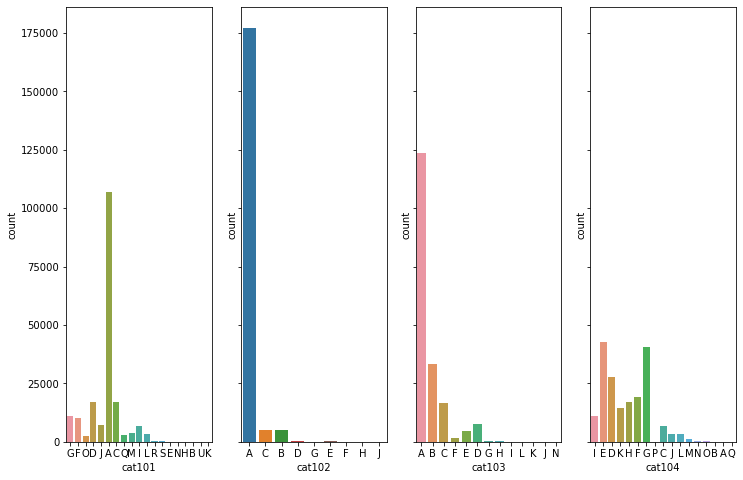

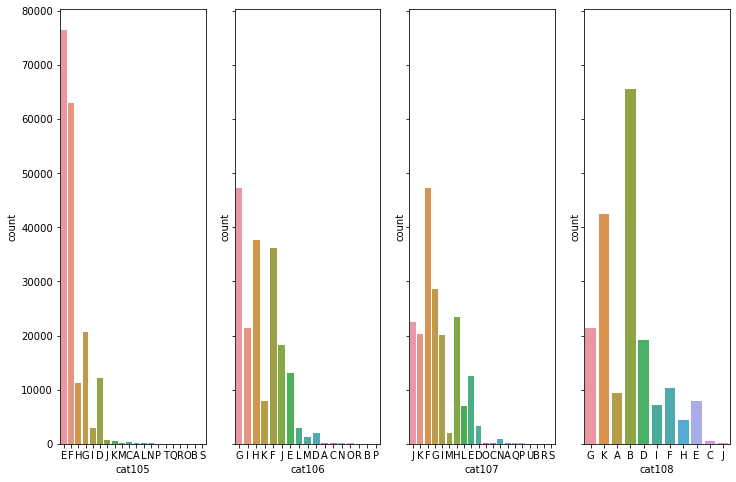

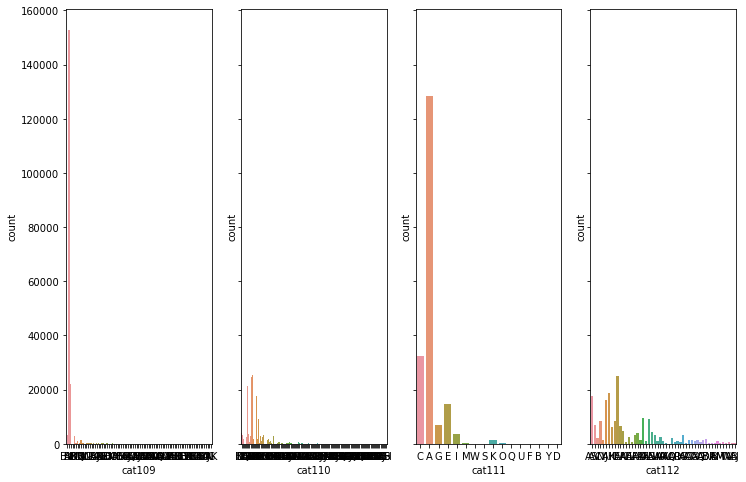

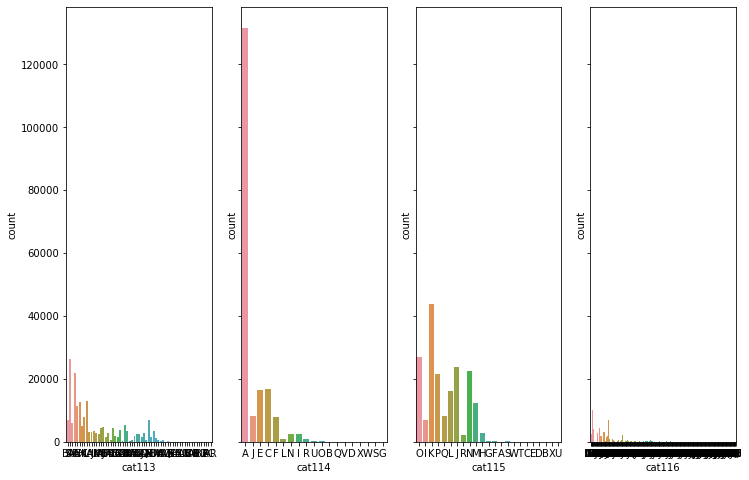

In [7]:
#Time to check out count plots of the categorical variables
#We can loop through all the cat columns to plot them

#There are 116 cat variables and 4 is a good number of charts per plot space,
#and 116 / 4 = 29, so 29 total plots are needed to get them all
#Because we are looking at counts, we can share the y-axis

n_cols = 4
n_rows = 29
for i in range(n_rows):
    fg, ax = plt.subplots(nrows = 1, ncols = n_cols, sharey = True, figsize = (12, 8))
    for j in range(n_cols):
        sns.countplot(x = df_columns[i * n_cols + j], data = df_cat, ax = ax[j])

Now that we have seen how the categorical features look, let's see the continuous features. 
Here we have histograms with densities as well as a kernel density estimation overlay to give a smoother picture of the distribution of the data.

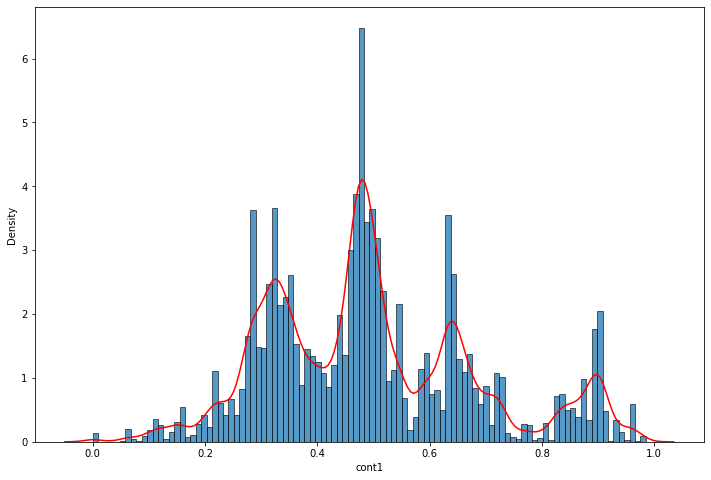

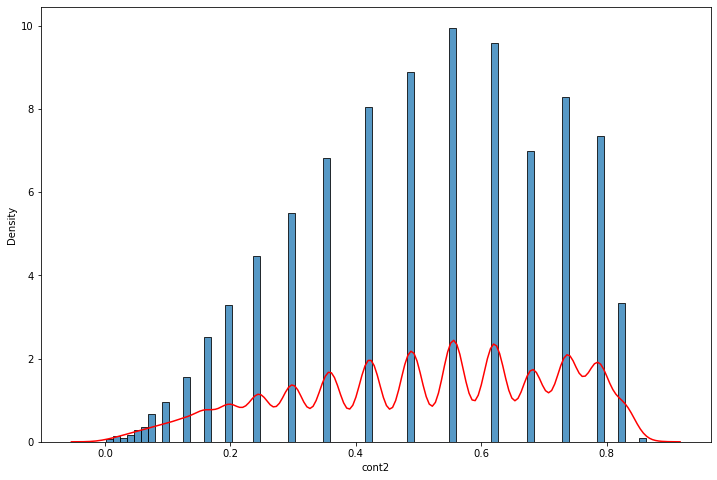

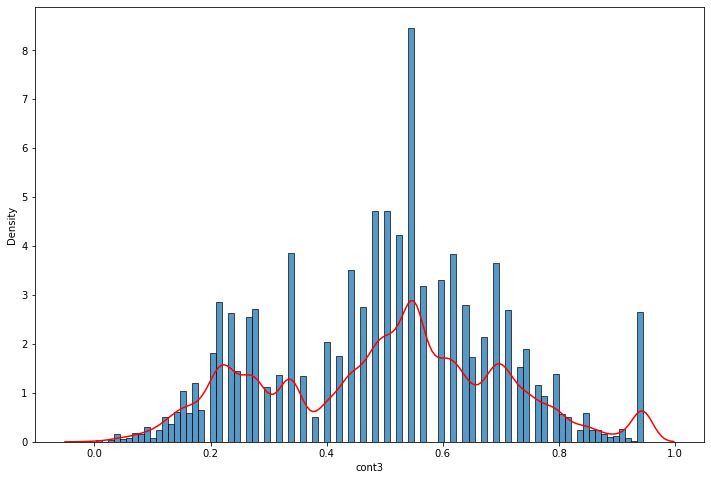

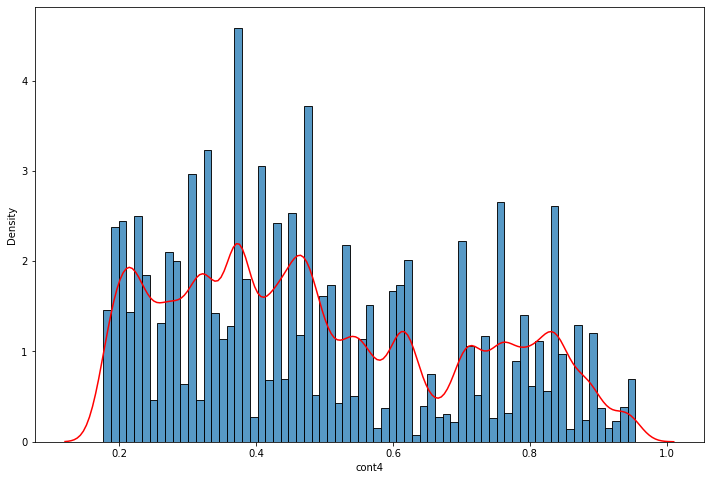

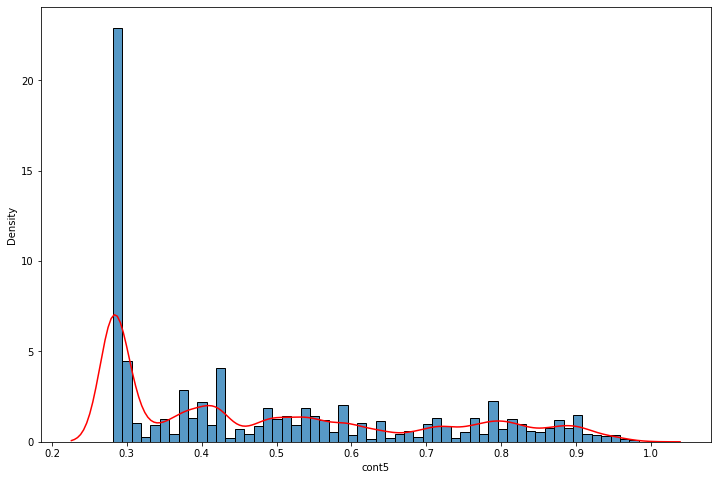

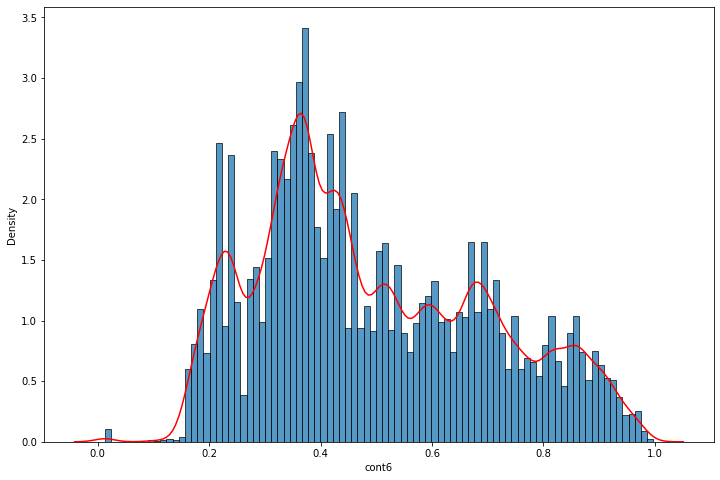

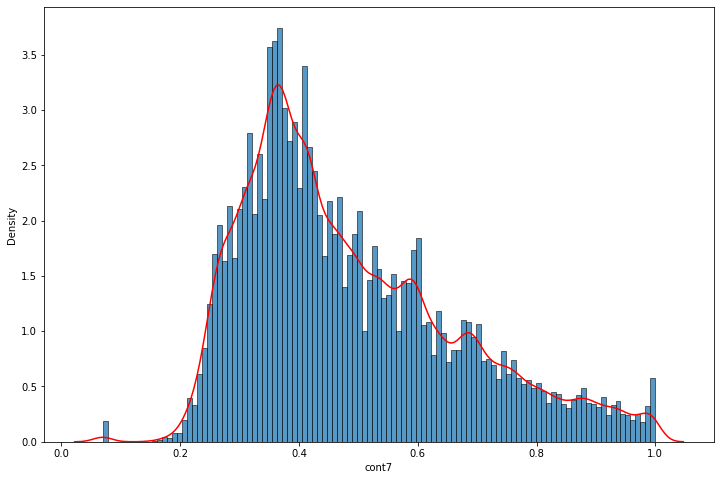

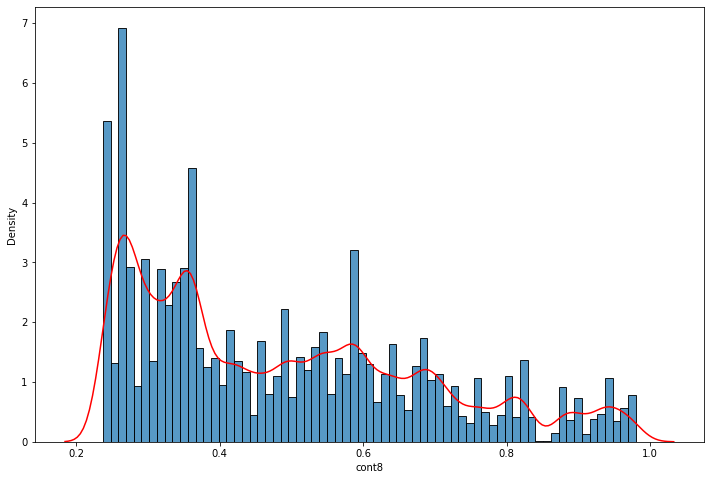

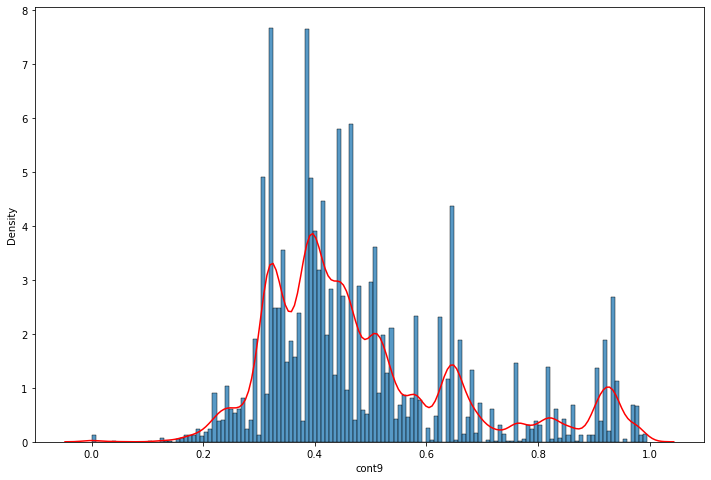

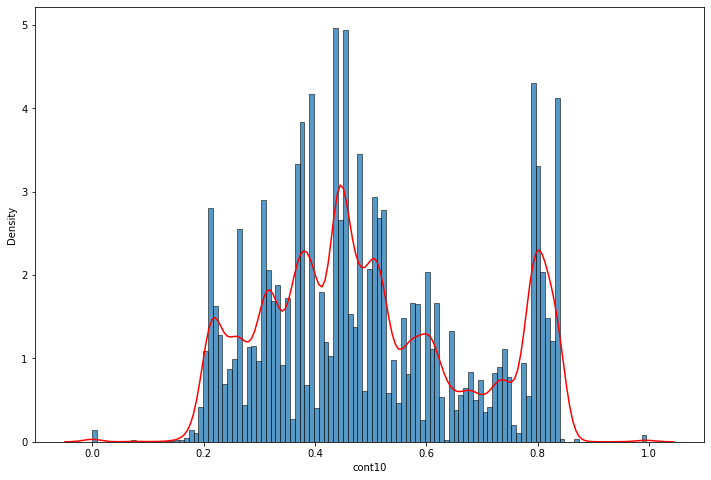

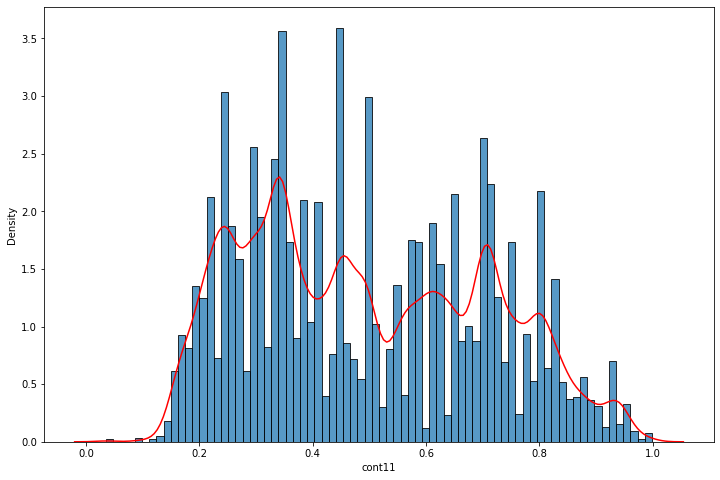

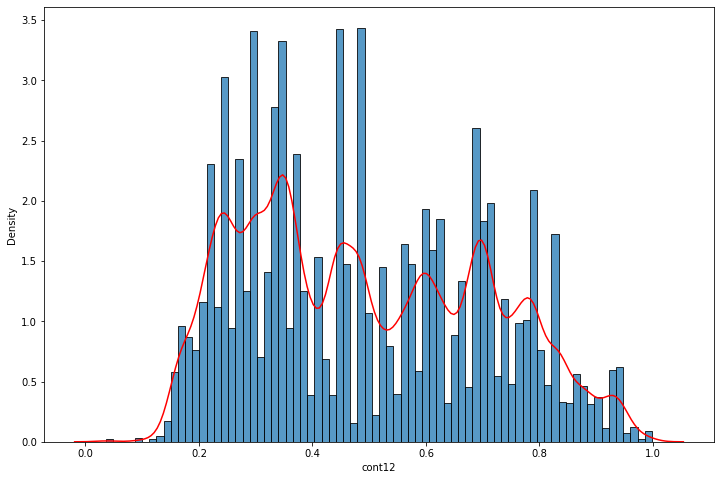

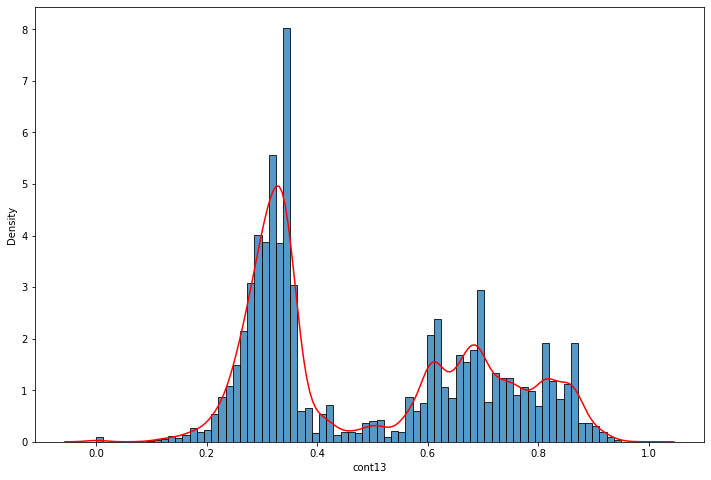

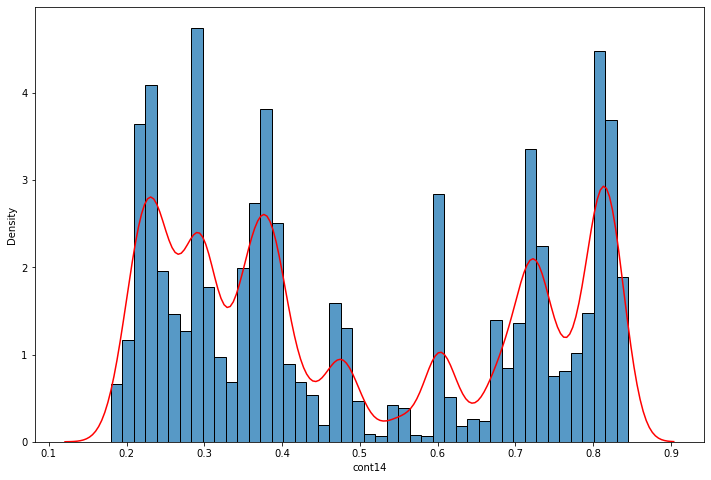

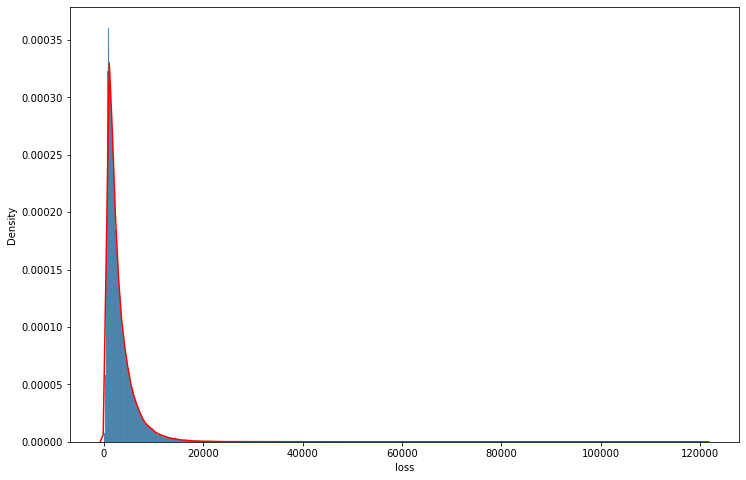

In [8]:
#And disrtibutions of the continuous featuresw
for i in range(len(df_cont.columns)):
    fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (12,8))
    sns.histplot(x = df_cont.columns[i], data = df_cont, stat = 'density')
    sns.kdeplot(x = df_cont.columns[i], data = df_cont, color = 'red')

To complete a view of the distributions of continuous features, a set of boxplots is created. This allows us to spot check for outliers ss well.

'cont7' and 'cont9' have the most outliers of the continuous features. As expected, the target 'loss', has many outliers - the few high severity losses. 

If we look back to the descriptive statistics from when we inspected the data, we see that the third quartile of the 'loss' is at 'loss' = 3864.045000. Beyond the whiskers are the outliers. Here, the whiskers end at Q3 + 1.5 * IQR and plugging in the values: 3864.045000 + 1204.460000 * 1.5 = 5670.735000. Therefore, our outliers lie above 5671 and there are 24,293 of them! 

However, if we perform a quick calculation for log('loss'), there are far fewer outliers, only 521. There are 255 outliers on the lower end and 266 on the upper end. Just a few moments ago, we saw that the distribution of 'loss' is roughly normal, meaning it is roughly symmetric about its mean, and so the number of outliers on either side being nearly equal is a good sign.

The end of the whiskers for 'loss' are at Q3 + 1.5*IQR which is 5670.735000000001
And there are 24293 outliers


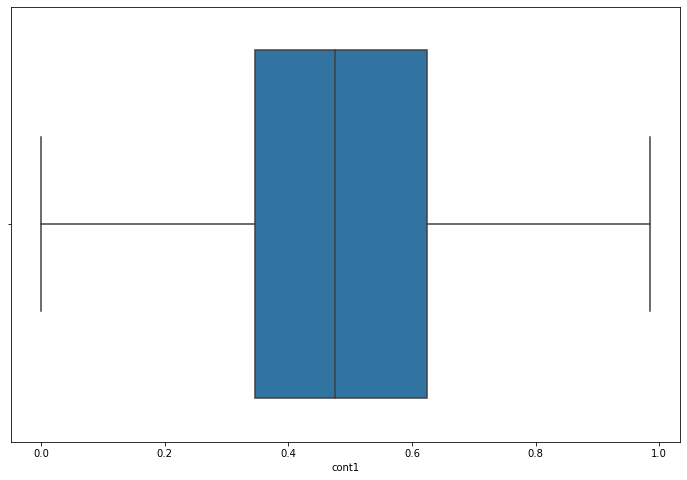

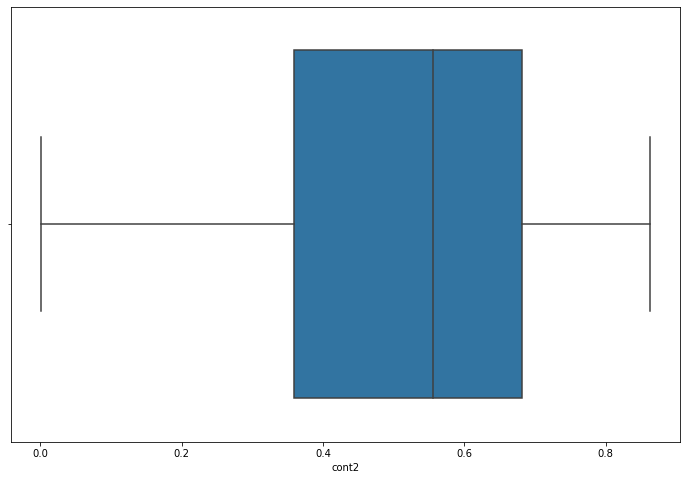

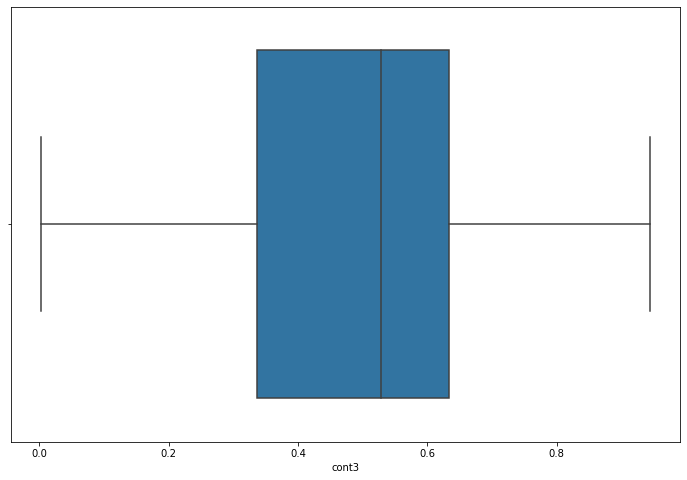

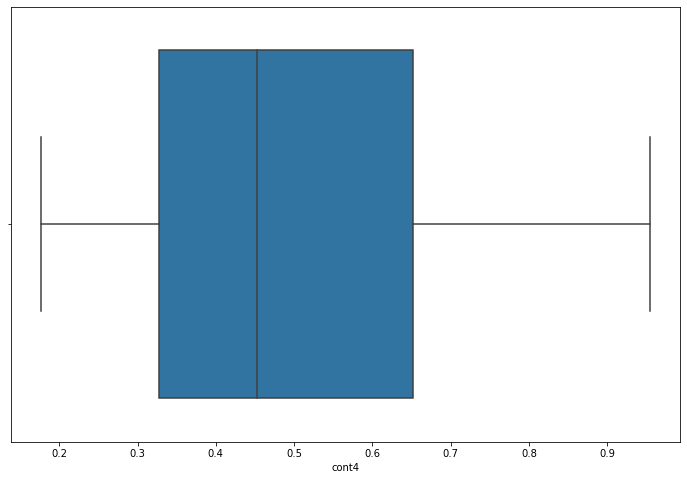

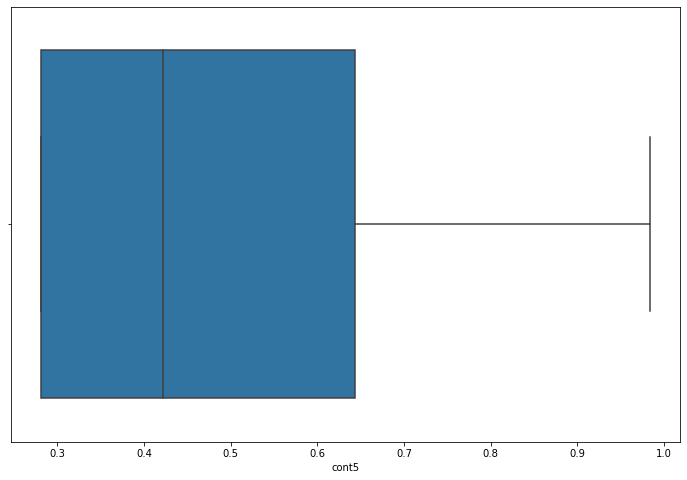

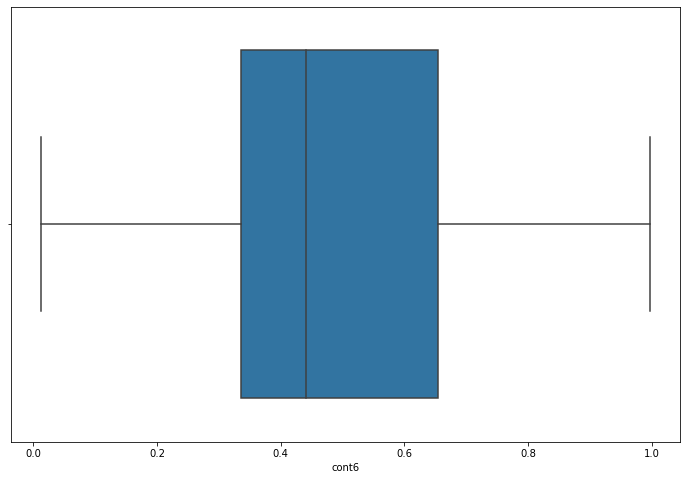

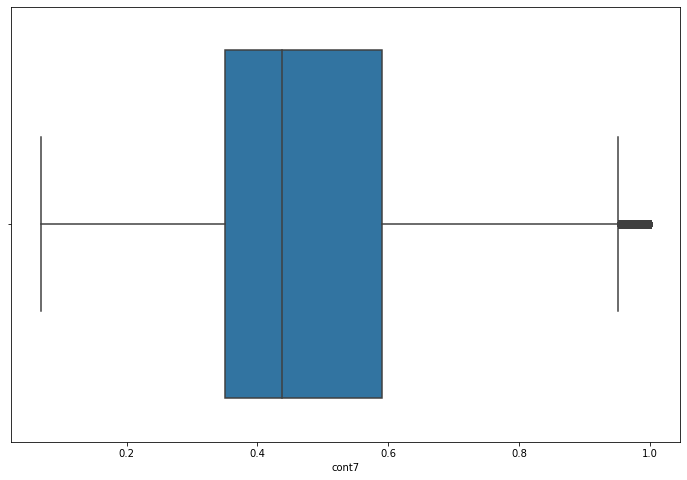

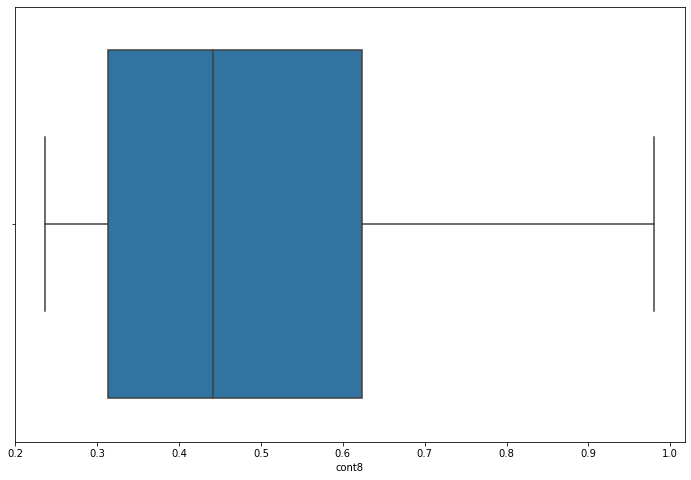

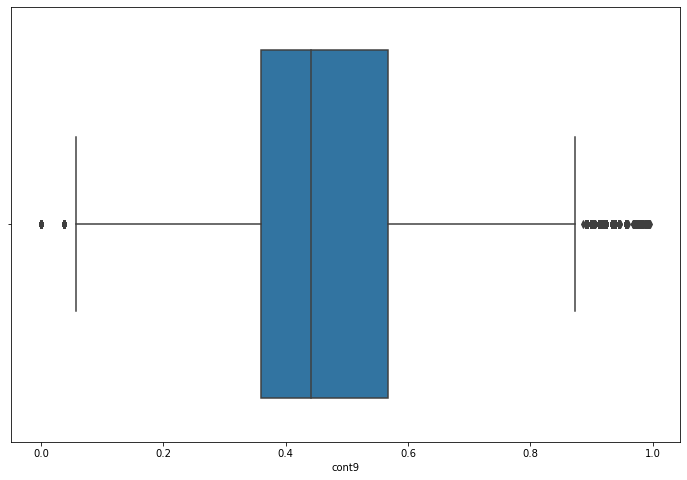

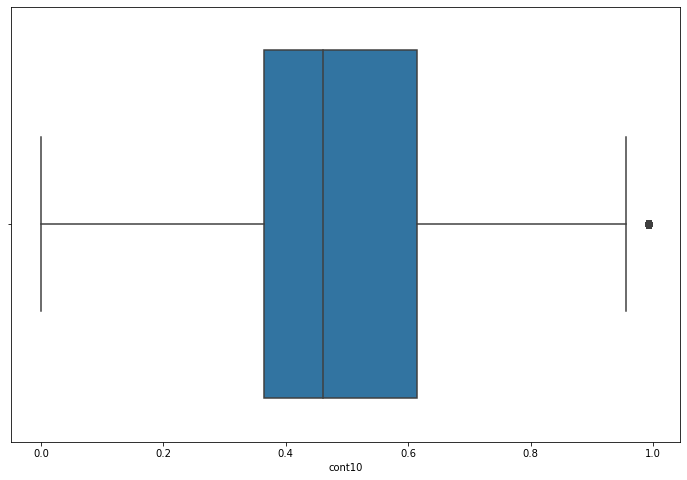

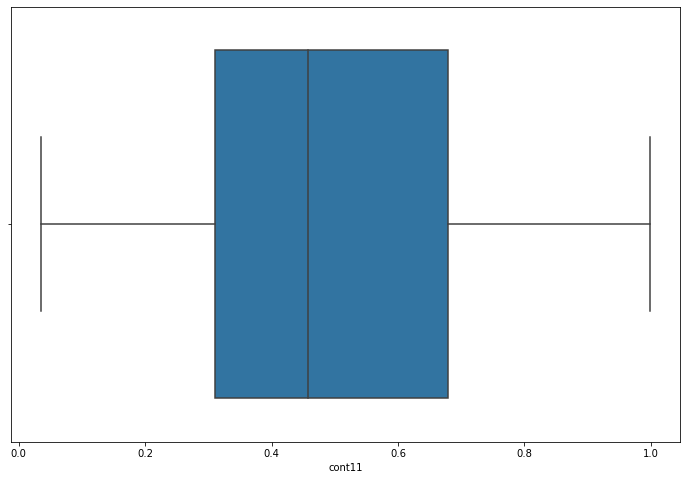

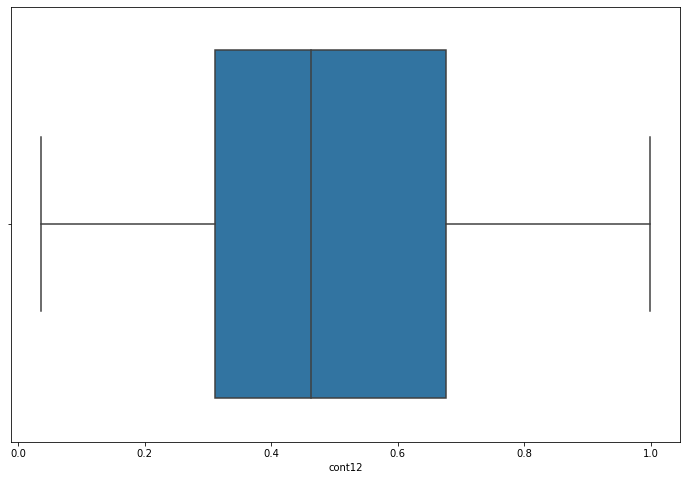

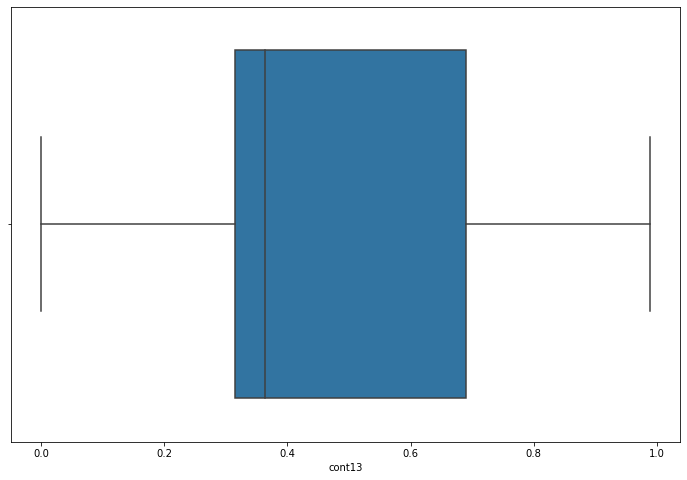

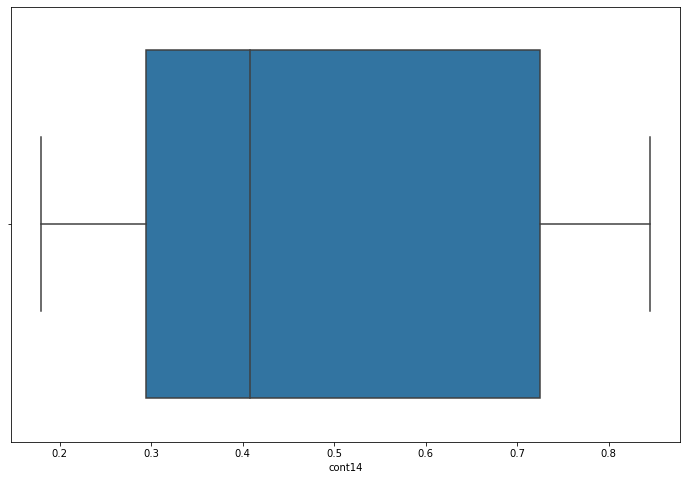

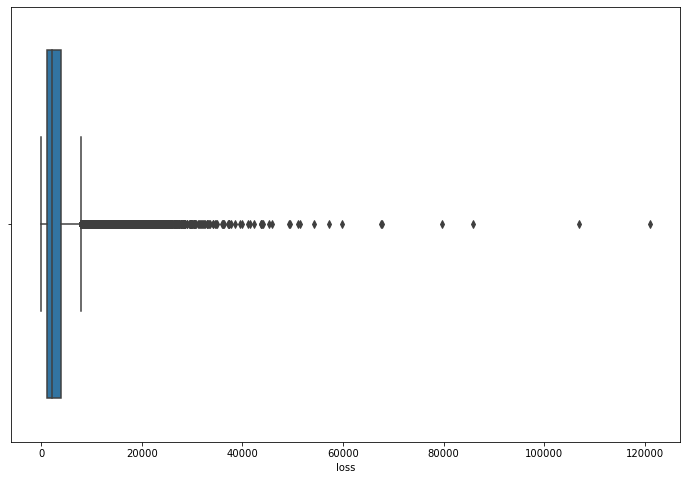

In [9]:
#Boxplots of the continuous features, any outliers?
for i in range(len(df_cont.columns)):
    fig, ax = plt.subplots(nrows=1, ncols = 1, figsize = (12,8))
    sns.boxplot(x = df_cont.columns[i], data = df_cont)
    
print("The end of the whiskers for 'loss' are at Q3 + 1.5*IQR which is", 3864.045000 + 1204.460000 * 1.5)
print("And there are {} outliers".format(np.sum(df['loss'] > 5671)))

Now looking at log('loss'): 
There are 255 outliers on the lower end.
There are 266 outliers on the upper end.
There are 521 outliers in the log('loss') distribution


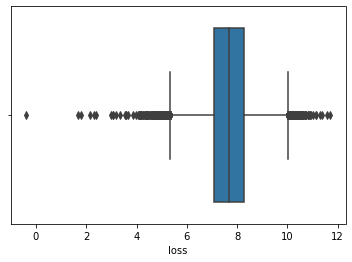

In [27]:
logtarget = np.log(df['loss'])
logtarget.describe()
q1 = 7.093787
q3 = 8.259470
iqr = q3 - q1
outlier_low = q1 - 1.5*iqr
outlier_up = q3 + 1.5*iqr
num_low = logtarget[logtarget <= outlier_low]
print("Now looking at log('loss'): ")
print("There are {} outliers on the lower end.".format(len(num_low)))
num_high = logtarget[logtarget >= outlier_up]
print("There are {} outliers on the upper end.".format(len(num_high)))
total_outliers = num_low + num_high
print("There are {} outliers in the log('loss') distribution".format(len(total_outliers)))


sns.boxplot(x = np.log(df['loss']), data = df)
plt.show()

Lastly, we want to examine the correlation structure of the continuous features to verify that there are no perfect multicolinearities. Some of the features have higher correlations, over 0.75, but none of them are perfect correlations so we do not need to make any adjustments. Also, note that none of the features here are highly correlated to the target.

We should be mindful that our correlation is Pearson's correleation which only measures the linear correlation between features. There may be nonlinear correlations.

<AxesSubplot:>

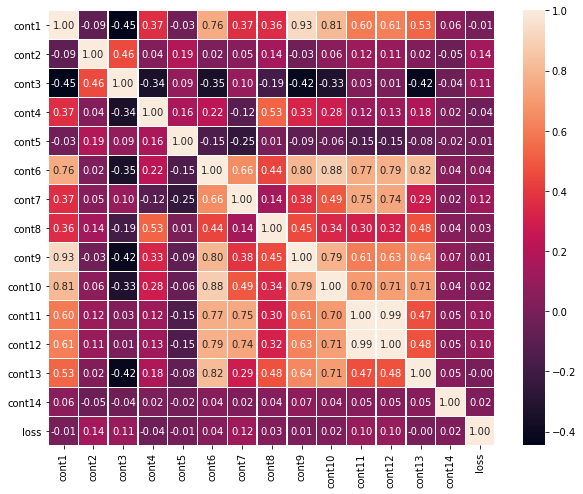

In [11]:
#Correlation heatmap
correlation = df_cont.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot = True, fmt = '.2f', linewidths = 0.5 )

With exploratory data analysis completed let's state what we have learned:

We have learned that the target variable, 'loss', follows a gamma distribution which leads us down the path of a generalized linear model. 

We saw that there are a good number of outliers here which is not a problem for us.

We also learned that the continuous features are not highly correlated with the target. Since the continuous features have various forms, we looked at boxplots to get a better idea of the distribution of the features. These features have very few outliers. 

We saw that the binary categorical features tend to favor one of the values over the other, and that for high cardinality categorical features, there is more balance.

## Modelling Stage I: Continuous Variables Only 


In the first modelling stage we are going to consider the set of continuous features. Here, we will follow the standard train-test-split pattern of setting up trainng and test sets followed by the fit-predict pattern. 

To start, we take the continuous features and separate them from the target, then perform an 80-20 train-test split. 

In [12]:
#Separate features and target, TTS

y = df_cont['loss'].values
X = df_cont.drop('loss', axis = 1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

### Linear Models: Linear Regression

We will now take a few moments to review linear regression!

Linear regression models are of the form $Y = X\beta.$

Here, Y is our target variable, also referred to as the response or dependent variable. X is a predictor variable, also called the independent variable. If X has more than one predictor, then X is a matrix of p predictors, also called the design matrix. $\beta$ is a  vector of coefficients (also called weights) assigned to each predictor in X. If X is just one predictor, then you may write $$y = \beta_{1} * X + \beta_{0}$$ where $\beta_{0}$ is an intercept term. If X is more than one predictor, $\beta_{0}$ is placed inside the beta vector and a single column of 1s is placed inside the design matrix X

In a formal sense, beta represents population parameters which are not perfectly knowable. In practice, we will have to estimate them. Our estimates are just that, estimates, so there will be deviations between what is observed and what our model predicts. To capture this, we add an error term to the linear model:

$$Y = X*\beta + \varepsilon$$

$\varepsilon$ is the error term for our model, defined as the difference between Y and $X * \beta.$ $\varepsilon$ captures unobserved effects and pure random error. 

The model that we estimate then is:

$$\hat Y = X * \hat\beta + \hat\varepsilon.$$

The goal of any statistical model is to produce accurate predictions with minimal error. To do this, we want to find an estimate for the $\hat\beta$ vector which gives us the smallest error possible. This presents an optimization problem which can be solved using the ordinary least squares approach. This approach considers the residual sum of squares, RSS, and seeks to minimize it. This optimization problem is convex and can be stated as:

$$\hat\beta = \underset{\beta} {\operatorname{argmin}} S (\beta)$$ where S is the objective function:

$$ RSS = \|Y - X * \beta\|_{2}^{2} = \sum_{i=1}^n \Big( y_{i} - \sum_{j=1}^{p} \beta_{j}^{T} * x_{i,j} \Big)^{2} = (Y - X*\beta)^{T} * (Y - X*\beta)$$

To find the minimum, we take the derivative of this function, set it equal to 0, and then solve for $\hat\beta$. I will skip over the math here because there are many excellent explanations of it elsewhere. However, when we do the math we end up with the following equation of $\hat\beta$:

$$\hat\beta = (X^{T}X)^{-1} X^{T}Y$$


This expression for $\hat\beta$ has convenient properties that guarantee it to be the only estimate which minimizes the sum of squared errors. In other words, $\hat Y = X\hat\beta + \hat\varepsilon$ has the smallest error, and the most accurate predictions!

But can we do better than this?
 
 
### Linear Models: Regularized Regression

Of course we can! 

To motivate regularized regression, we have to consider a problem central to supervised learning: the bias-variance tradeoff. The bias-variance tradeoff pertains to the differences in a model's performance between its training data and its test data, or any new data that is fed into the model. 

A model's error can be decomposed into three pieces: error due to bias, due to variance, and due to irreducible error. Bias results from the assumptions made about the relationship between the predictors and the target. Variance is the sensitivity of a model to fluctuations in the training data used to fit the model versus the test data. Irreducible error is error that cannot be captured in the modelling process. Broadly speaking, irreducible error is noise in the data. 

We want to build a model with low bias and low variance. However, bias and variance are inversely related, to increase one is to decrease the other. A model with low bias and high variance makes few assumptions about the relationship between the target and the predictors, but will have inconsistent performance across different data sets, while a model with high bias and low variance will make strong assumptions about that relationship and have relatively consistent performance across different datasets. 

In general, linear models have high bias (linearity is a very strong assumption) and low variance, that is, the main source of error for a linear model is from the assumption of linearity, and not from performance on different data. These models are likely to underfit the training data they are given. An example of a model with low bias and high variance is the decision tree which is notorious for having excellent training performand and very poor testing performance. Models such as decision trees or other non-linear models tend to overfit the training data.



Regularization is the process of increasing a model's error due to bias to reduce its error due to variance to achieve better performance. For linear regression models, the most common regularization methods are ridge, LASSO (Least Absolute Shrinkage and Selection Operator), and a combination of the two called elastic net.

Since the RSS objective function minimizes the error of the model, adding to it *increases* the error and moves it away from the minimum thereby increasing the error on training data in an effort to reduce error (due to variance) on testing data.

Increasing the error of the model means adding a regularization (or penalty) term, R, to the objective function:

$$RSS = S(\beta) = \| Y - X\beta \|_{2}^{2} + R.$$

For LASSO regularization, $R = \lambda\|\beta\|_{1} = \lambda \sum_{j=1}^p |\beta_{j}|$. LASSO is best used in situations where you have good reason to believe that many coefficients will not be important, and only a few features significantly impact the model. The LASSO will push those values to zero and they will drop out of the model. We say that LASSO is able to perform feature selection by keeping only those features whose values are different from zero. $\lambda$ in LASSO regularization is a hyperparameter which controls the strength of the regularization. The best choice for $\lambda$ is found using cross-validation and a few different values of the $\lambda$ to identify the value which maximizes performance relative to your objective function. If $\lambda$ is set to zero, we return to the standard linear regression model.


For Ridge regularization, $R = \lambda \|\beta\|_{2}^{2} = \sum_{j=1}^{p} \beta_{j}^{2}$. Ridge, on the other hand, is best used in situations where you believe that many parameters will significantly impact the model and take on similar values. In this case, you may want to reduce the impact of some of the features, but not to zero. The $\lambda$ in ridge, like the $\lambda$ in LASSO, controls the strength of the ridge regularization and can be tuned by using cross-validation. Just like in LASSO, if $\lambda$ is set to zero, the ridge is reduced to the standard linear regression. A quick example of when ridge is useful is a situation where you may have multicolinearities or many highly ocrrelated features.


And for elastic net regularization, we combine the two and set $$R = \alpha (L1\_ratio * \|\beta\|_{1}) + 0.5*(1 - L1\_ratio)*\|\beta\|_{2}^{2},$$ where $$L1\_ratio = \frac{\lambda_{1}}{\lambda_{1} + \lambda_{2}}.$$ Models with a large number of features and many samples generally benefit from using the elastic net. In the elastic net, we want to use a linear combination of LASSO and ridge. To achieve this, we calculate a ratio of $\lambda_{1}$ and $\lambda_{2}$, perform the sum, and adjust the strength of the combined regularization using $\alpha$, which serves the same purpose as the lambdas in LASSO or ridge, and is found in the same mannner. If the $L1\_ratio = 1$, then the L2 term cancels to zero and we have a pure LASSO model. Similarly, if the $L1\_ratio = 0$, the L1 term cancels and we have a ridge model. This model can be further reduced to a standard linear regression just as the others, can you guess how?


**It should be noted here that glmnet in R and sklearn in Python have slightly different calculations and notations. If you are working in both languages you should be careful. In the remarks above, the sklearn notation is used and can be found at: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html. ** 

That's enough about linear regression, we are ready to start modelling! 

The approach for our linear models is to initialize the models, put them into a list so we can loop over them. We also intialize three dictionaries, one for each metric to be used later. In our loop, we are going to fit, predict, and record our three metrics: MAE, MSE, and $R^{2}$ score. From there, we will create a scatter plot for each model. Lastly, we grab the feature importances and plot them three ways: unsorted, sorted, non-zero sorted. Ridge will not remove any features as Lasso will, we can assume the Ridge plots will be identical. 

Based off of our exploratory data analysis, it is safe to say that the linear regression model will probably perform poorly. We also put our GammaRegressor here which sklearn has implemented as a generalized linear model using the log link function.

Lastly, we will utilize sklearn's ElasticNetCV to perform five-fold cross-validation, check the parameters, and then update our metrics. 


In [13]:
"""Linear Regression and Regularization"""

#Initialize models to loop over

lin_reg = LinearRegression()
lasso = Lasso()
ridge = Ridge()
gamma_reg = GammaRegressor() 
elastic_net = ElasticNet()

models = [lin_reg, lasso, ridge, gamma_reg, elastic_net]
cont_model_mae_dict = {}
cont_model_mse_dict = {}
cont_model_score_dict = {}

LinearRegression() has mae of  1947.2972071793129
LinearRegression() has MSE of  7978864.528223786
LinearRegression() score is  0.03941475469957978
LinearRegression() params are  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


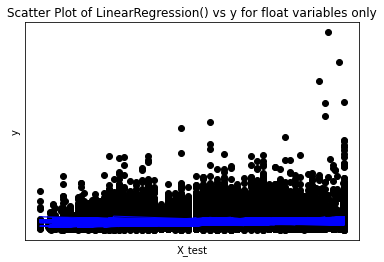

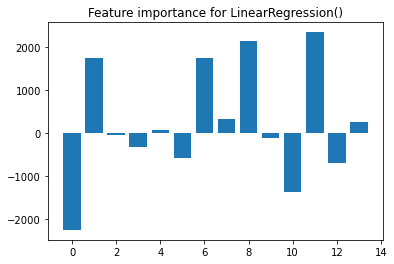

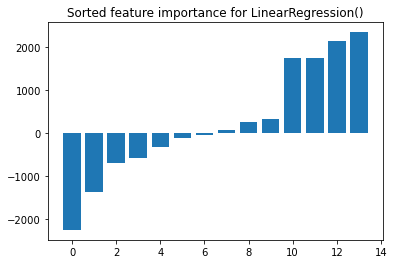

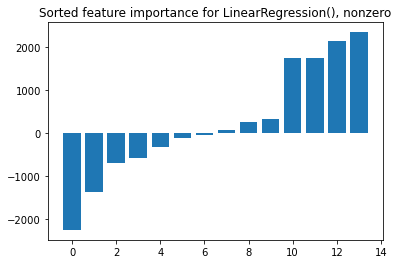

Lasso() has mae of  1946.8705947212616
Lasso() has MSE of  7981417.528180924
Lasso() score is  0.03910739591670975
Lasso() params are  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


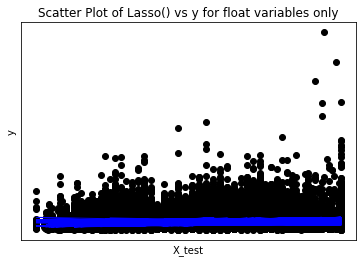

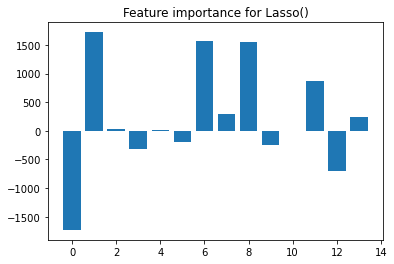

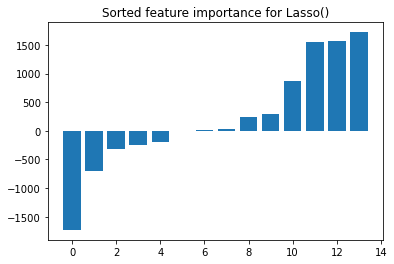

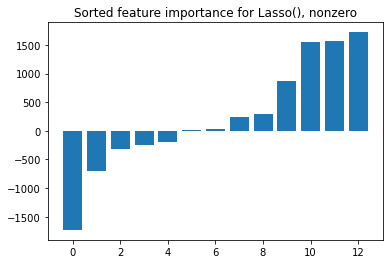

Ridge() has mae of  1947.2878282138654
Ridge() has MSE of  7978905.918857157
Ridge() score is  0.03940977163067694
Ridge() params are  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


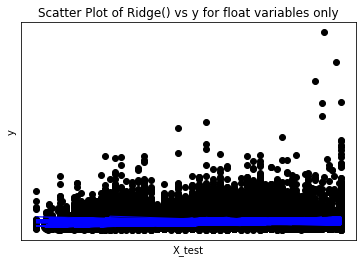

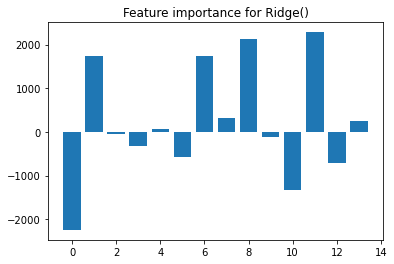

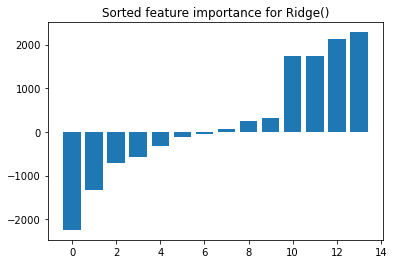

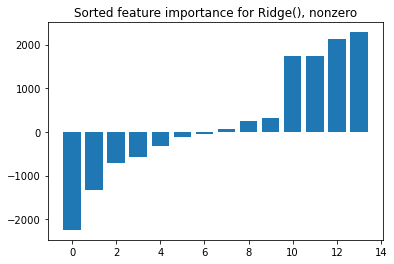

GammaRegressor() has mae of  1957.0281254997612
GammaRegressor() has MSE of  8264410.978484408
GammaRegressor() score is  0.006854102973748666
GammaRegressor() params are  {'alpha': 1.0, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


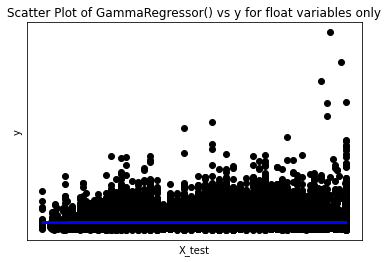

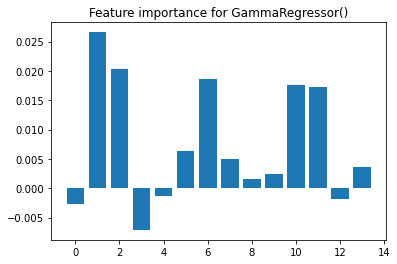

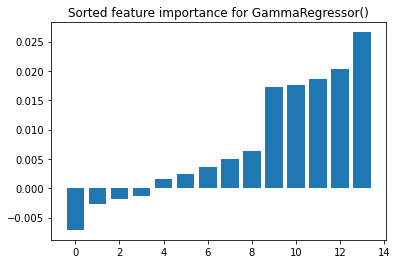

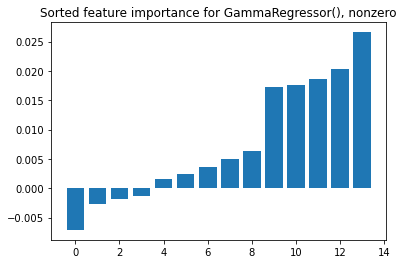

ElasticNet() has mae of  1956.430749703464
ElasticNet() has MSE of  8232180.42640846
ElasticNet() score is  0.008917744337330835
ElasticNet() params are  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


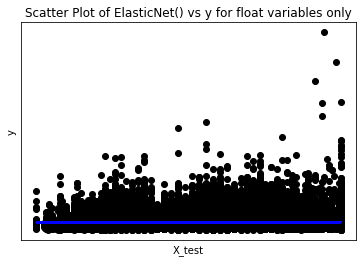

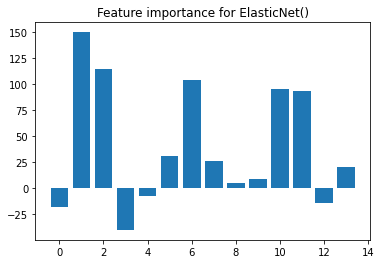

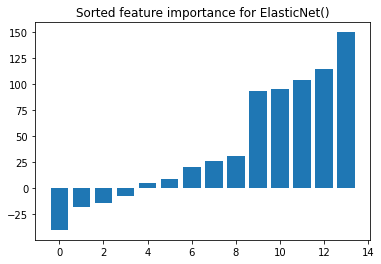

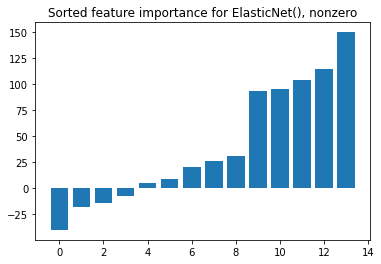

MAE of models  {LinearRegression(): 1947.2972071793129, Lasso(): 1946.8705947212616, Ridge(): 1947.2878282138654, GammaRegressor(): 1957.0281254997612, ElasticNet(): 1956.430749703464}
MSE of models  {LinearRegression(): 7978864.528223786, Lasso(): 7981417.528180924, Ridge(): 7978905.918857157, GammaRegressor(): 8264410.978484408, ElasticNet(): 8232180.42640846}
R^2 of models  {LinearRegression(): 0.03941475469957978, Lasso(): 0.03910739591670975, Ridge(): 0.03940977163067694, GammaRegressor(): 0.006854102973748666, ElasticNet(): 0.008917744337330835}


In [14]:
#This is the model routine which will loop over each model, fit it, record metrics and parameters, 
#It will then make a scatter plot for the regression line, as well as feature importances both unsorted and sorted, and lastly
#it will plot feature importances of non-zero features

for model in models:
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = MAE(y_test, y_pred)
    mse = MSE(y_test, y_pred)
    model_score = model.score(X_test, y_test)
    param_dict = model.get_params(deep = True) #check for correctness and the print statement
    
    cont_model_mae_dict[model] = mae
    cont_model_mse_dict[model] = mse
    cont_model_score_dict[model] = model_score
    
    
    print(model, "has mae of ", mae)
    print(model, "has MSE of ", mse)
    print(model, "score is ", model_score)
    print(model, "params are ", param_dict)
    
    
    plt.scatter(X_test[:, np.newaxis, 2], y_test,  color='black')
    plt.plot(X_test[:, np.newaxis, 2], y_pred, color='blue', linewidth=1)
    plt.xticks(())
    plt.yticks(())
    plt.title("Scatter Plot of {} vs y for float variables only".format(model))
    plt.xlabel("X_test")
    plt.ylabel("y")
    plt.show()
    
    #plotting important features
    importance = model.coef_

    plt.bar([x for x in range(len(importance))], importance)
    plt.title("Feature importance for {}".format(model))
    plt.show()

    #And the sorted importances
    
    importance.sort()
    plt.bar([x for x in range(len(importance))], importance)
    plt.title("Sorted feature importance for {}".format(model))
    plt.show()
    
    #And sorted > 0
    importance_short = importance[importance != 0]
    plt.bar([x for x in range(len(importance_short))], importance_short)
    plt.title("Sorted feature importance for {}, nonzero".format(model))

    plt.show()
    
print("MAE of models ", cont_model_mae_dict)
print("MSE of models ", cont_model_mse_dict)
print("R^2 of models ", cont_model_score_dict)
    

In [15]:
"""ElasticNetCV"""

#We then examine a cross-validated elastic net
#I like dialogue with the model so I like to set verbose to high levels

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100]
elastic_cv = ElasticNetCV(cv = 5, alphas = alphas, n_alphas = 12, l1_ratio = 0.5, verbose = 10, n_jobs = -1, random_state = 42)

elastic_cv.fit(X_train, y_train)
elastic_cv_pred = elastic_cv.predict(X_test)

elastic_cv_param = elastic_cv.get_params(deep = True)
print(elastic_cv_param)

elastic_cv_mae = MAE(y_test, elastic_cv_pred)
print('elastic_cv MAE: ', elastic_cv_mae)

elastic_cv_mse = MSE(y_test, elastic_cv_pred)
print('elastic_cv MSE: ', elastic_cv_mse)

elastic_cv_score = elastic_cv.score(X_test, y_test)
print('elastic cv score: ', elastic_cv_score)

print('elastic cv alpha: ', elastic_cv.alpha_)

cont_model_mae_dict[elastic_cv] = elastic_cv_mae
cont_model_mse_dict[elastic_cv] = elastic_cv_mse
cont_model_score_dict[elastic_cv] = elastic_cv_score

(array([-0.        ,  0.68502235,  0.2996198 , -0.        , -0.        ,
        0.        ,  0.26690767,  0.        ,  0.        ,  0.        ,
        0.23374702,  0.21387542, -0.        ,  0.        ]), 0.0, 88407843.8106647, 3)(array([-0.        ,  0.70068178,  0.32373515, -0.        , -0.        ,
        0.        ,  0.22370476,  0.        ,  0.        ,  0.        ,
        0.18922704,  0.16860518, -0.        ,  0.        ]), -0.0001220703125, 89188181.84040494, 3)

(array([-0.        ,  0.71370587,  0.33303114, -0.        , -0.        ,
        0.        ,  0.2634865 ,  0.        ,  0.        ,  0.        ,
        0.21608109,  0.1984892 , -0.        ,  0.        ]), 0.0001220703125, 89584359.25498219, 3)(array([-0.        ,  0.72349068,  0.32313501, -0.        , -0.        ,
        0.        ,  0.27661937,  0.        ,  0.        ,  0.        ,
        0.24531493,  0.22580992, -0.        ,  0.        ]), 0.0001220703125, 90802916.1104997, 3)
(array([-0.        ,  1.24570653, 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


{'alphas': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75, 100], 'copy_X': True, 'cv': 5, 'eps': 0.001, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'n_alphas': 12, 'n_jobs': -1, 'normalize': False, 'positive': False, 'precompute': 'auto', 'random_state': 42, 'selection': 'cyclic', 'tol': 0.0001, 'verbose': 10}
elastic_cv MAE:  1944.4568317701494
elastic_cv MSE:  8026036.627575969
elastic cv score:  0.03373564804633766
elastic cv alpha:  0.05




After fitting our first set of models there are a few obsevartions we can make!

To start off, the linear regression plots clearly provide little to no information in a scenario with 14 features.

But more importantly we should compare the different models.

If we take a gander at the MSE numbers, they are incredibly high. In fact, they are in dollars-squared! Allstate is an American insurance company and therefore prices its claims losses in dollars. So, it makes total sense to be using MAE over MSE. If I had just one square dollar I would be the richest person in the world! From here on out we include MSE as a reference.

We knew going into this initial process that the linear regression models would perform poorly. LASSO performs best when it has a lot of features to work with, while ridge works best when features have similar coefficients. Therefore, if both of these are the case, elastic net may perform better than either. Let's see how our models stack up.

Our MAE scores look far more reasonable, all around 1950. With the standard linear regression as our base, the MAE is 1947. Not surprisingly, LASSO and ridge performed better. Surprisingly, not much better. The default elastic net performed *worse* which is interesting, while the gamma regression model performed worst of all with a MAE of 1957. 

We also cross-validated the elastic net and this model performed the best of the bunch with a MAE of 1944, expectedly. 

Our $R^{2}$ scores measure the amount of variation in the data explained by our features. Since none of the $R^{2}$ scores break 0.04, we can safely conclude that these features are insufficient in explaining variability.

Let's take full control of this dataset and perform our modelling again on all features!

## Modelling Stage II: One-hot Encoding


Our dataset today contains 116 categorical variables. Categorical variables can take many forms, sex = (male, female), credit score = (bad, fair, good, excellent), country = (Canada, USA, Mexico), and many other forms. Sometimes order does not matter, such as gender or country, so we call these nominal. Other times the order will matter such as in credit scores and so we call them ordinal. Performing mathematics on categories is a strange concept and so we would like to somehow transform these variables into numerical features. One-hot encoding is a common technique for transforming categorical variables into numerical features. 

The origin of the term one-hot encoding lies in digital circuity where bits in a group can take only the values 0 or 1. In machine learning, this means taking categorical variables and transforming their values into new features which map the previous values into 0 or 1 depending on whether or not that value is observed for that sample. For example, if we are looking to create a new auto insurance rating scheme for drivers in New York, Connecticuit, and New Jersey, we might collect data on several thousand drivers and create a categorical variable called 'State' which would contain either NY, CT, or NJ depending on where the driver lives. To one-hot encode this feature, we would create three new features, State_NY, State_CT, and State_NJ. These three new features would be binary, taking on 0 or 1, depending on where the driver lives. If a selected driver lives in CT, we would see State_NY = 0, State_CT = 1, and State_NJ = 0. Notice that we created a number of new features equal to the number of unique values in the original categorical variable. 

There are different implementations of one-hot encoding methods and some allow for the option of dropping the first value. In some cases, we may want to allow zero to represent more than just the absence of a value. Perhaps we would like NY to be a sort of default location for a driver. We can represent this by allowing a 0 value to be NY. Then, we would only create two new features (number of unique values minus one), State_CT and State_NJ. If the values for State_CT and State_NJ are both equal to 0, then the driver cannot be from nowhere, so they must be from NY! More generally, if all features created from the original categorical value are equal to 0, we conclude that the observation is part of the default category. 

This can become quite expensive in large datasets such as ours or far larger datasets such as images, natural language, and more.

In our dataset, we have some categorical variables with just 2 unique values, and some with dozens. This would be ridiculous to do on our own and we can simply use the Pandas function pd.get_dummies(). One caveat to using this function is that it returns a data frame and so takes up more memory. There are more efficient methods such as sklearn's OneHotEncoder() object.

After performing our one-hot encoding using pd.get_dummies(), we have a grand total of 1153 features! Wow! WIth our categorical variables transformed into numerical features, we are ready to model!

Going into this next stage of modelling, we can reason a little bit about how our models will perform. Linear Regression will likely perform worse than the other models, but more dramatically. With 1153 features, LASSO will likely perform very well as not all of the features are going to be important and so will drop out of the final model. Ridge may perform better than linear regression because of its penalty on many large features. However, without bringing any features to zero, it might not be as effective as LASSO. In this case, I think the elastic net will perform better than either LASSO or ridge individually, especially if we cross-validate. As for gamma, it will certainly perform better than the linear regression, based on the distribution of the target feature. Yet its performance on the continuous features suggests it might not perform as well as the others.

The procedure will be the same as before: split the data, place the models in a list, loop over the models to fit, predict, and score. Next in the loop is plotting the line of best fit, plotting feature importances, sorted, and sorted and not equal to zero. 

In [16]:

"""________________________Modelling Stage II. All Features____________________"""

#One hot encoding all of the features into a pandas data frame

df_oh = pd.get_dummies(df)
print(df_oh.shape)
print(df_oh.head())

y_all = df_oh['loss'].values
X_all = df_oh.drop('loss', axis = 1).values


X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size = 0.3, random_state=42)

(188318, 1154)
       cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
id                                                                         
1   0.726300  0.245921  0.187583  0.789639  0.310061  0.718367  0.335060   
2   0.330514  0.737068  0.592681  0.614134  0.885834  0.438917  0.436585   
5   0.261841  0.358319  0.484196  0.236924  0.397069  0.289648  0.315545   
10  0.321594  0.555782  0.527991  0.373816  0.422268  0.440945  0.391128   
11  0.273204  0.159990  0.527991  0.473202  0.704268  0.178193  0.247408   

      cont8    cont9   cont10  ...  cat116_P  cat116_Q  cat116_R  cat116_S  \
id                             ...                                           
1   0.30260  0.67135  0.83510  ...         0         0         0         0   
2   0.60087  0.35127  0.43919  ...         0         0         0         0   
5   0.27320  0.26076  0.32446  ...         0         0         0         0   
10  0.31796  0.32128  0.44467  ...         0         0        

In [17]:
"""Linear Regression and Regularization"""

lin_reg_all = LinearRegression()
lasso_all = Lasso()
ridge_all = Ridge()
gamma_reg_all = GammaRegressor() 
elastic_net_all = ElasticNet()

full_models = [lin_reg_all, lasso_all, ridge_all, gamma_reg_all, elastic_net_all]

full_model_mae_dict = {}
full_model_mse_dict = {}
full_model_score_dict = {}

LinearRegression() has mae of  145339089808.21817
LinearRegression() has MSE of  1.9765319283743714e+26
LinearRegression() score is  -2.3795709283514696e+19
LinearRegression() params are  {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


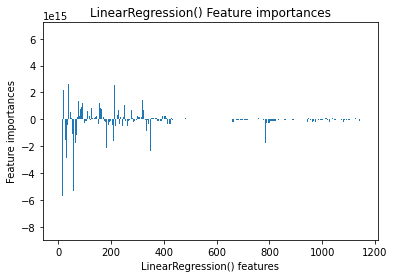

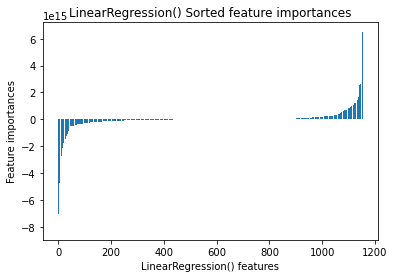

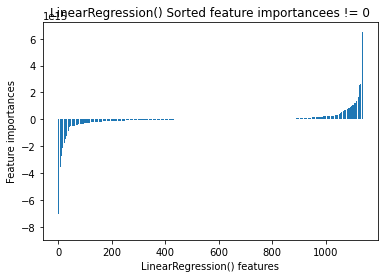

Lasso() has mae of  1298.6900775628728
Lasso() has MSE of  4135356.269284224
Lasso() score is  0.5021394081471735
Lasso() params are  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


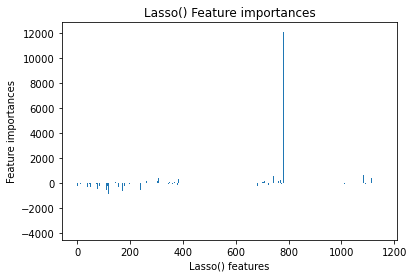

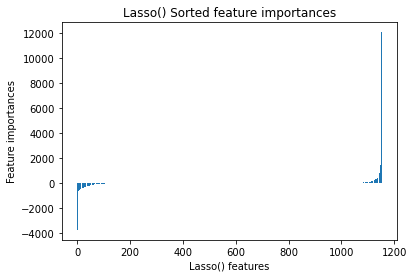

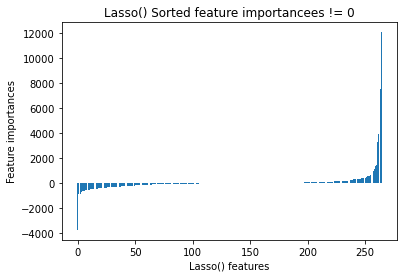

Ridge() has mae of  1300.5689909917621
Ridge() has MSE of  4160279.776059717
Ridge() score is  0.4991388367268924
Ridge() params are  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'normalize': False, 'random_state': None, 'solver': 'auto', 'tol': 0.001}


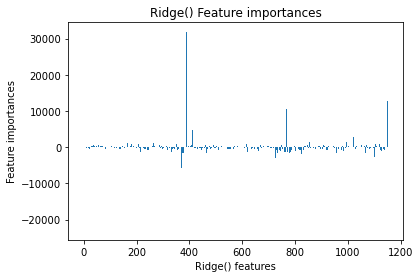

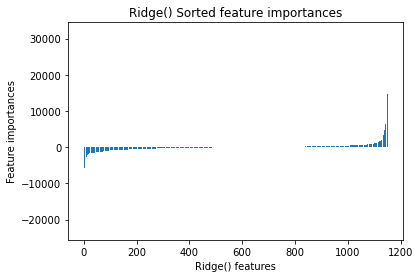

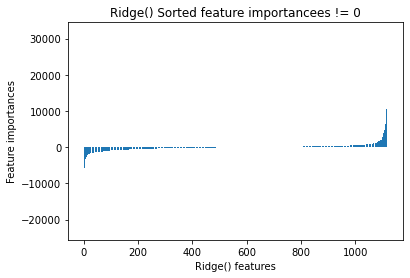

GammaRegressor() has mae of  1502.1933333201257
GammaRegressor() has MSE of  5848589.01936775
GammaRegressor() score is  0.35286504264414054
GammaRegressor() params are  {'alpha': 1.0, 'fit_intercept': True, 'max_iter': 100, 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


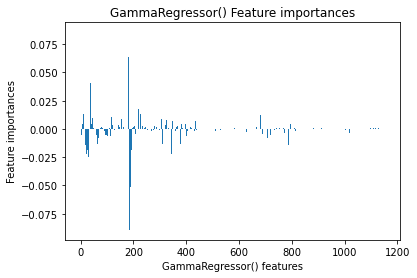

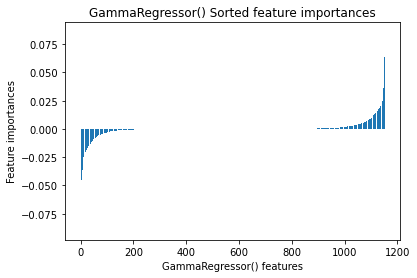

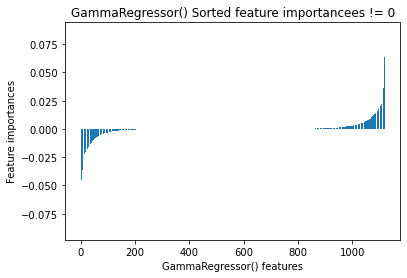

ElasticNet() has mae of  1439.629417211139
ElasticNet() has MSE of  5164816.026902119
ElasticNet() score is  0.3782014906276694
ElasticNet() params are  {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'l1_ratio': 0.5, 'max_iter': 1000, 'normalize': False, 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False}


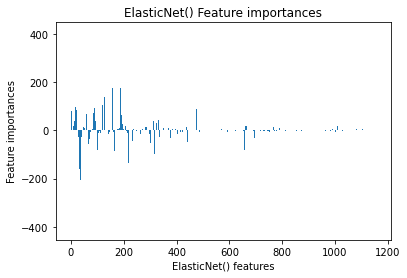

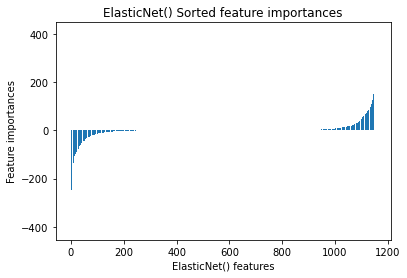

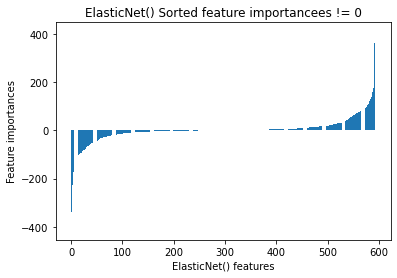

In [18]:
#Fit the models, get the scores, print the scores, plot the feature importances

for model in full_models:
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    mae = MAE(y_test, y_pred)
    mse = MSE(y_test, y_pred)
    model_score = model.score(X_test, y_test)
    param_dict = model.get_params(deep = True) 
    
    full_model_mae_dict[model] = mae
    full_model_mse_dict[model] = mse
    full_model_score_dict[model] = model_score
    
    print(model, "has mae of ", mae)
    print(model, "has MSE of ", mse)
    print(model, "score is ", model_score)
    print(model, "params are ", param_dict)

        
    #plotting important features
    importance = model.coef_

    plt.bar([x for x in range(len(importance))], importance)
    plt.title('{} Feature importances'.format(model))
    plt.xlabel('{} features'.format(model))
    plt.ylabel('Feature importances')
    plt.show()

    #And the sorted importances
    
    importance.sort()
    plt.bar([x for x in range(len(importance))], importance)
    plt.title('{} Sorted feature importances'.format(model))
    plt.xlabel('{} features'.format(model))
    plt.ylabel('Feature importances')
    plt.show()
    
    #And sorted > 0
    importance_short = importance[importance != 0]
    plt.bar([x for x in range(len(importance_short))], importance_short)
    plt.title('{} Sorted feature importancees != 0'.format(model))
    plt.xlabel('{} features'.format(model))
    plt.ylabel('Feature importances')
    plt.show()
    
    



In [19]:
"""ElasticNetCV"""

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
elastic_cv_all = ElasticNetCV(cv = 5, alphas = alphas, l1_ratio = 0.5, verbose = 10, n_jobs = -1, random_state = 42)

elastic_cv_all.fit(X_train, y_train)
elastic_cv_all_pred = elastic_cv_all.predict(X_test)


#Compute metrics
elastic_cv_all_mae = MAE(y_test, elastic_cv_all_pred)
print('elastic_cv_all MAE: ', elastic_cv_all_mae)

elastic_cv_all_mse = MSE(y_test, elastic_cv_all_pred)
print('elastic_cv_all MSE: ', elastic_cv_all_mse)

elastic_cv_all_score = elastic_cv_all.score(X_test, y_test)
print('elastic_cv_all Score: ', elastic_cv_all_score)

full_model_mae_dict[elastic_cv_all] = elastic_cv_all_mae
full_model_mse_dict[elastic_cv_all] = elastic_cv_all_mse
full_model_score_dict[elastic_cv_all] = elastic_cv_all_score

print("MAE ", full_model_mae_dict)
print("MSE ", full_model_mse_dict)
print("R^2 ", full_model_score_dict)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


(array([-0.        ,  1.27889023,  0.76758323, ...,  0.        ,
        0.        ,  0.        ]), 1596.71875, 89584359.25498219, 4)(array([-0.        ,  1.26201769,  0.75484661, ...,  0.        ,
        0.        ,  0.        ]), 1566.4964599609375, 89188181.84040494, 4)

(array([-0.        ,  2.38227775,  1.61906216, ...,  0.        ,
        0.        ,  0.        ]), 4324.7633056640625, 89188181.84040494, 4)(array([-0.        ,  2.40717468,  1.6382582 , ...,  0.        ,
        0.        ,  0.        ]), 4412.4989013671875, 89584359.25498219, 4)

(array([-0.        ,  4.63929418,  3.35083147, ...,  0.        ,
        0.        ,  0.        ]), 50702.20556640625, 89584359.25498219, 4)
(array([-0.        ,  4.59893024,  3.31858951, ...,  0.        ,
        0.        ,  0.        ]), 50628.90295410156, 89188181.84040494, 4)
(array([-0.        ,  9.99857034,  7.42343626, ...,  0.        ,
        0.        ,  0.        ]), 63301.21691894531, 89188181.84040494, 5)
(array([-0.      

[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.4s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   11.4s remaining:    7.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.6s finished


elastic_cv_all MAE:  1301.023890499474
elastic_cv_all MSE:  4250840.819150668
elastic_cv_all Score:  0.48823608214515135
MAE  {LinearRegression(): 145339089808.21817, Lasso(): 1298.6900775628728, Ridge(): 1300.5689909917621, GammaRegressor(): 1502.1933333201257, ElasticNet(): 1439.629417211139, ElasticNetCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], cv=5,
             n_jobs=-1, random_state=42, verbose=10): 1301.023890499474}
MSE  {LinearRegression(): 1.9765319283743714e+26, Lasso(): 4135356.269284224, Ridge(): 4160279.776059717, GammaRegressor(): 5848589.01936775, ElasticNet(): 5164816.026902119, ElasticNetCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75], cv=5,
             n_jobs=-1, random_state=42, verbose=10): 4250840.819150668}
R^2  {LinearRegression(): -2.3795709283514696e+19, Lasso(): 0.5021394081471735, Ridge(): 0.4991388367268924, GammaRegressor(): 0.35286504264414054, ElasticNet(): 0.3782014906276694, ElasticNetCV(alphas=[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 3

Afte completing this procedure for the models with a full set of features, one-hot encoded categorical features as well as our continuous features, we have some things to discuss.

Right off the bat, the linear regression model's performance seems like an error, the MAE is in the billions! It is not an error though. The $R^{2}$ of this model is effectively 0. With this many features, and so many features which do not have strong linear relationships with the target, this makes sense. The relationship between the features and target loses near all of the explanatory power it had when only continuous features were included. 

Of the models where performance improved, the gamma regressor came in with MAE of 1502, beating its prior performance of 1957. Still, the gamma regressor did not perform as well as other models.

As for the regularized models, LASSO outperformed both ridge and the cross-validated elastic net with an MAE of 1298. LASSO was able to reduce the number of features in its model from 1153 down to 265, an amazing reduction of 888 features. To see this, we run $1153 - len(lasso\_all.coef\_[lasso\_all.coef\_ != 0]$. We subset the lasso_all coefficient array such that the remaining coefficients are not equal to 0. LASSO is known for its feature selection ability and it sure pays off! LASSO also tops off the $R^{2}$ scores with a value of 0.502, the only model to break 0.50 as well.

The effectiveness of cross-validation can be seen by examining the MAE and $R^{2}$ of the default elastic net and the cross-validated elastic net. Elastic net gives us MAE of 1439 and $R^{2}$ of 0.378 while the elastic net CV gives us MAE of 1301 and $R^{2}$ of 0.488. 

Now that we have achieved a great linear regression model with LASSO, let's see if we boost our performance further with a totally different approach!

### Gradient Boosting Regression 

A more modern approach to classification and regression problems is to use a gradient boosting machine. Gradient boosting is an ensemble method which combines so-called weak learners (usually using decision trees) to create a strong learner. Weak learners are simpler models which make predictions that are just barely better than random guessing. In using weak learners, we are able to separate simple patterns in the data from more complex patterns. 

Gradient boosting generalizes its predecessor, AdaBoost, by allowing for any differentiable loss function to be used in the process of building a strong learner. 

Gradient boosting works by starting with an intial prediction for the target value of the samples. In regression problems, it is common to use the average value of the target. Then, we begin building our first decision tree. This tree is built based on the residuals from the intial guess. The target variable in this model becomes the residuals rather than the original target value of interest. The predictions of our first tree are scaled by a learning rate, and added to the initial guess. This sum becomes the new prediction for the original target. We use this prediction to calculate new residuals, fit a new tree to those residuals, add the new predictions to those of the prior terms, and start again. We repeat this process until we reach the number of trees specified or until the model achieves a perfect fit. Along the way, the predicted residuals become smaller and smaller as the objective function is minimized and our weak learners team up to create a strong learner!

Formally, the gradient boosting algorithm looks like this:

**Step 0:** Start with your features and target, $\{(x_{i}, y_{i})\}_{i=1}^{n}$,and a differentiable loss function L(y, F(x)). 
    Here, F(x) is the function which generates your predicted values. The most common loss function in gradient boosting regression problems is the residual sum of squares, SSR. 

**Step 1:** Calculate the initial prediction as follows: $F_{0}(x) = \underset{\gamma} {\operatorname{argmin}} \sum_{i=1}^{n} L(y_{i}, \gamma).$

Argmin is a function that outputs the value of $\gamma$ which minimizes the sum of the loss function outputs. To find this value of $\gamma$ we take the derivative with respect to $\gamma$, set it equal to 0, and solve for $\gamma$. 
    
   Since gradient boosting takes many derivatives, a way of making the math easier to compute is to take one-half the SSR as follows: 
   

$$SSR = \frac{1}{2} \sum_{i=1}^n (y_{i} - \gamma)^{2}$$
    
The derivative of MSE with respect to y_pred is:
$$\frac{\partial RSS}{\partial \gamma} = -\sum_{i=1}^n(y_{i} - \gamma).$$
   
Setting this equal to 0,

$$-\sum_{i=1}^n(y_{i} - \gamma)=0$$

implies that
     
$$\gamma = \frac{1}{n}\sum_{i=1}^{n}y_{i}.$$


In other words, the value of $\gamma$ which minimizes the SSR is simply the average of our target variable. Great! Now we are ready to move to the bulk of this algorithm!


**Step 2:** M is the number of weak learners which will be used. So, for m = 1 to M we perform the following:

A. Compute pseudo-residuals  for i = 1,...n
$$r_{i,m} = -\Big[\frac{\partial{L(y_{i}, F(x_{i}))}}{\partial{F(x_{i})}}\Big]_{F(x) = F_{m-1}(x)}.$$
   
This is the gradient of the loss function. These residuals are called pseudo-residuals because any differentiable loss function can be used, not just SSR.
       Since the gradient of the loss function returns a negative (pseudo) residual, we multiply this expression by -1 so that we no longer have the negative residual. For m = 1, $F(x_{i}) = F_{0}(x_{i})$ which is simply $\gamma$, the average.
    
B. Fit a weak learner, $h_{m}(x)$, to the residuals using the features x and the residuals, $\{(x_{i}, r_{i,m})\}_{i=1}^{n}$ as our target. Create terminal regions $R_{j,m}$ for $j = 1, ... J_{m}.$ These are the leaves in the decision tree.
    
C. For $j = 1,...,J_{m}$ calculate $\gamma_{j,m}$ as follows:

$$\gamma_{j,m} = \underset{{\gamma}} {\operatorname{argmin}} \sum_{x_{i} \in R_{j,m}}L(y_{i}, F_{m-1}(x_{i}) + \gamma).$$

This procedure is similar to the procedure in Step 1 for finding a starting value for $F_{0}(x)$. There are two differencs. First, we are choosing only those $x_{i}s$ which fall into a particular terminal region. Second, instead of using just the average of the target, we are adding the previous model to $\gamma.$.
        
D. Update the model: $F_{m}(x) = F_{m-1}(x) + \sum_{j=1}^{J_{m}} \gamma_{j,m} I(x \in R_{j,m})$

The summation ensures that we add up the outputs $\gamma_{j,m}$ for all leaves $R_{j,m}$ in which an observation, x, is present. This makes sure that we have accounted for observations which appear in multiple leaves.

**Step 3:** Return $F_{M}(x)$


In summary, we create an initial prediction, the average, and sequentially fit decision trees to the residuals between the observed value and the predicted value of the target. Then, we scale the outputs from the decision trees and add them to the prior prediction. Over the number of decision trees specified, the total model becomes more accurate. After the model reaches the specified number of decision trees, we have our final model on the training data. We can then begin predicting on the test set, evaluating the model, and tuning its hyperparameters.


For our purposes, we will only create one gradient boosting regressor. This is to save on the runtime of the algorithm. Normally, we would work on hyperparameters about the entire model such as n_estimators and learning_rate, and perhaps max_features. 
    There are also hyperparameters overseeing the decision trees used as weak learners. We might wish to test several values for max_depth, min_samples_split, and min_samples_leaf. We can control how deep the tree goes, the number of samples per split of nodes within the tree, and the number of samples to create a leaf. 
    There are several other hyperparameters we may wish to tune depending on the characteristics of our problem, but for now we do not need to worry about them. 
    
If we were hyperparameter tuning our gradient boosting regressor, we would use GridSearchCV with a parameter grid as a dictionary and a desired number of folds, say 5. 

Today we will use 200 decision trees with default values for the rest of the hyperparameters described above. 
    learning_rate = 0.1
    max_features = 'auto'  (the number of features)
    max_depth = 3
    min_samples_split = 2
    min_samples_leaf = 1
    
The code below initializes the regressor, fits it to the training data, and makes a prediction. We also add our performance metrics for this model to the respective dictionaries. 


Warning: This code may take up to 20 minutes to execute completely. 

In [20]:
"""_________________________Modelling Stage III._________________________
            ____________Gradiesnt Boosting Regression______________"""
            
# Initialize gbr model
gbr = GradientBoostingRegressor(max_depth=3, 
            n_estimators=200,
            verbose = 10,
            random_state=1337)


# Fit gbr to the training set
gbr.fit(X_train, y_train)

# Predict test set labels
gbr_y_pred = gbr.predict(X_test)


# Compute metrics
mae_gbr = MAE(y_test, gbr_y_pred)
mse_gbr = MSE(y_test, gbr_y_pred)
score_gbr = gbr.score(X_test, y_test)
gbr_params = gbr.get_params(deep = True)


full_model_mae_dict[gbr] = mae_gbr
full_model_mse_dict[gbr] = mse_gbr
full_model_score_dict[gbr] = score_gbr

# Print metrics
print('Test set MSE of gbr: {}'.format(mse_gbr))
print("Test set MAE of gbr: {}".format(mae_gbr))
print('Test set score of gbr: {}'.format(score_gbr))
print('gbr parameters: {}'.format(gbr_params))

      Iter       Train Loss   Remaining Time 
         1     7942272.2548           22.15m
         2     7499995.0794           22.17m
         3     7123810.5601           21.87m
         4     6784367.3806           21.62m
         5     6507904.5178           21.35m
         6     6282243.4229           20.96m
         7     6073522.9362           20.82m
         8     5896427.4279           20.71m
         9     5750253.0949           20.57m
        10     5610339.9418           20.50m
        11     5488455.5873           20.33m
        12     5383242.5001           20.15m
        13     5285575.6211           20.02m
        14     5197702.2312           19.90m
        15     5114129.7022           19.76m
        16     5032176.0831           19.56m
        17     4964766.4537           19.37m
        18     4903050.3770           19.29m
        19     4849846.5796           19.23m
        20     4796741.2878           19.15m
        21     4744567.0827           19.05m
        2

Now that the model has finished running, let's take a look at its performance. 

With an MAE of 1222 and an $R^2$ score of 0.548, the gradient boosting regressor beats out all of the linear regression variants including the LASSO model.

Below we define a simple function to plot feature importances for the GBR. It takes in an array of feature importances and a dataframe. It sorts the features by index and assigns them a position in the plot. For variety, we plot them horizontally. 

We create the array of feature importances by accessing the feature_importances_ attribute of the GBR model object, sort them by id, and plot. Due to the large number of features, a dictionary is created with feature:feature_importance pairs sorted. This is for readability. 

Many of the features are unimportant, having importance close to or equal to zero. As such, we subset the feature importances accordingly and plot them as well. A separate dict is also created from the prior dictionary using a comprehension. Lastly, we view the top ten features.

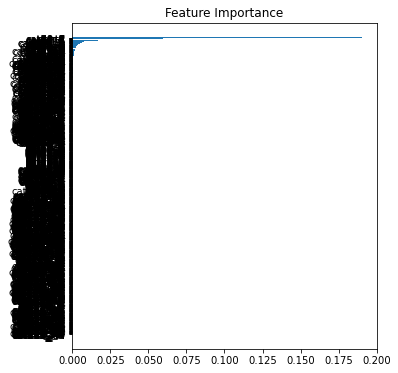

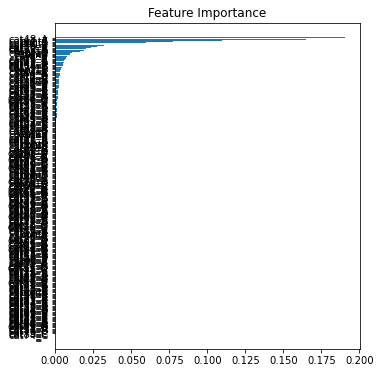

Number of feature importances:  1153
Number of nonzero feature importances:  245
Top ten features:  [('cat80_A', 0.19052650940790894), ('cat79_C', 0.1650367264280633), ('cont7', 0.1099058256717102), ('cat80_C', 0.07724703835632124), ('cont2', 0.05965575305835361), ('cat56_B', 0.04889086923285205), ('cat81_C', 0.032341775667240204), ('cat11_B', 0.0271495506804348), ('cat57_A', 0.02373142103951938), ('cat87_A', 0.02051290096145238)]


In [21]:
def plot_feat_imp(feat_imps, df):
    sorted_idx = np.argsort(feat_imps)
    pos = np.arange(sorted_idx.shape[0]) + .5
    fig = plt.figure(figsize = (12, 6))
    plt.subplot(1, 2, 1)
    plt.barh(pos, feat_imps[sorted_idx], align = 'center')
    plt.yticks(pos, np.array(df.columns)[sorted_idx])
    plt.title('Feature Importance')
    plt.show()
    

feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)

#Plot the full set of features and have a dict for readability
plot_feat_imp(feature_importance, df = df_oh)
feat_imp_dict = dict(zip(np.array(df_oh.columns)[sorted_idx], feature_importance[sorted_idx]))


#And do the same thing for features > 0 by dict comping the original
feat_imp_short = feature_importance[feature_importance > 0] #so we can plot both sets of features
feat_imp_dict_short = {k: v for k,v in sorted(feat_imp_dict.items(), key = lambda item: item[1], reverse = True) if v > 0}

plot_feat_imp(feat_imp_short, df = df_oh)

print('Number of feature importances: ', len(feature_importance))
print('Number of nonzero feature importances: ', len(feat_imp_short))

print("Top ten features: ", [(k,v) for k,v in feat_imp_dict_short.items()][0:10])


We would like to examine the variance of the GBR between the training and test sets. Below is a procedure which plots the deviance of the GBR over each set of data across the 200 trees.

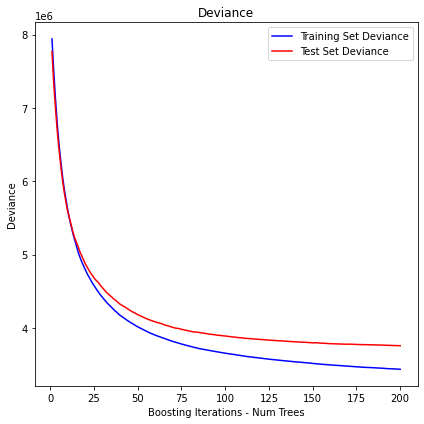

In [22]:
#Plot the training and test set deviance
test_score = np.zeros((gbr_params['n_estimators'],), dtype=  np.float64)
for i, y_pred in enumerate(gbr.staged_predict(X_test)):
    test_score[i] = gbr.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title('Deviance')
plt.plot(np.arange(gbr_params['n_estimators']) + 1, gbr.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(gbr_params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations - Num Trees')
plt.ylabel('Deviance')
fig.tight_layout()
plt.show()


Lastly, we would like to take a gander at each model's performance metrics compared to each other.
To do this we build a simple barplot function which takes in two arguments. First, a dictionary which consists of a performance metric for a number of models. Second, a string specifying which metric is being examined. 

The function builds a barplot based on the data within the dictionary and labels the plot based on the metric specified. 

In [23]:
"""_____________________________Model Evaluation__________________"""

#Barplot function to compare each model across each metric 

def barplot_metrics(model_dict, metric = ['mae', 'mse', 'score']):
    fig, ax = plt.subplots(figsize = (12, 8))

    plt.bar(range(len(model_dict)), list(model_dict.values()), align = 'center')
    
    plt.title("{} of Models".format(metric), fontsize = 18)

    # Set the x-axis tick labels to the model names
    plt.xlabel("Models")
    plt.xticks(range(len(model_dict)), list(model_dict.keys()), rotation = 90)

    # Set the y-axis 
    plt.ylabel("{}".format(metric))
    
    plt.show()


Along the way we built dictionaries to store models and their metrics. When building the dictionaries, the keys did not remain as defined. For example, 'lin_reg' the name assigned to the model object LinearRegression() is replaced with the model object as the key. Instead of (lin_reg, metric) we have (LinearRegression(), metric). As a result, looping and accessing becomes problematic.

To deal with this, we reconstruct each of the dictionaries by looping over the key-value pairs of the originals and casting the keys as strings. This way, we can perform our tasks. 

This is done once for the models using only the continuous variables, and then again for the models using all features, the so-called full models. 

In the full models, MSE and MAE for the vanilla linear regression model are so large that they dominate the plots, leaving the others invisible. For these plots, we remove the vanilla linear regression and plot accordingly. 

In [24]:
#First the cont models
cont_model_mae_dict2 = {}
for k,v in cont_model_mae_dict.items():
    cont_model_mae_dict2[str(k)] = v

cont_model_mse_dict2 = {}
for k,v in cont_model_mse_dict.items():
    cont_model_mse_dict2[str(k)] = v

cont_model_score_dict2 = {}
for k,v in cont_model_score_dict.items():
    cont_model_score_dict2[str(k)] = v
    
#Then put them back into a list
cont_model_metrics = [cont_model_mae_dict2, cont_model_mse_dict2, cont_model_score_dict2]



#and then full models
full_model_mae_dict2 = {}
for k,v in full_model_mae_dict.items():
    full_model_mae_dict2[str(k)] = v

full_model_mse_dict2 = {}
for k,v in full_model_mse_dict.items():
    full_model_mse_dict2[str(k)] = v

full_model_score_dict2 = {}
for k,v in full_model_score_dict.items():
    full_model_score_dict2[str(k)] = v
    
#Then put them back into a list
full_model_metrics = [full_model_mae_dict2, full_model_mse_dict2, full_model_score_dict2]

#And remove linear regression
for i in full_model_metrics:
    del i['LinearRegression()']

#To pair with our dictionaries in the loops
metrics = ['mae', 'mse', 'score']

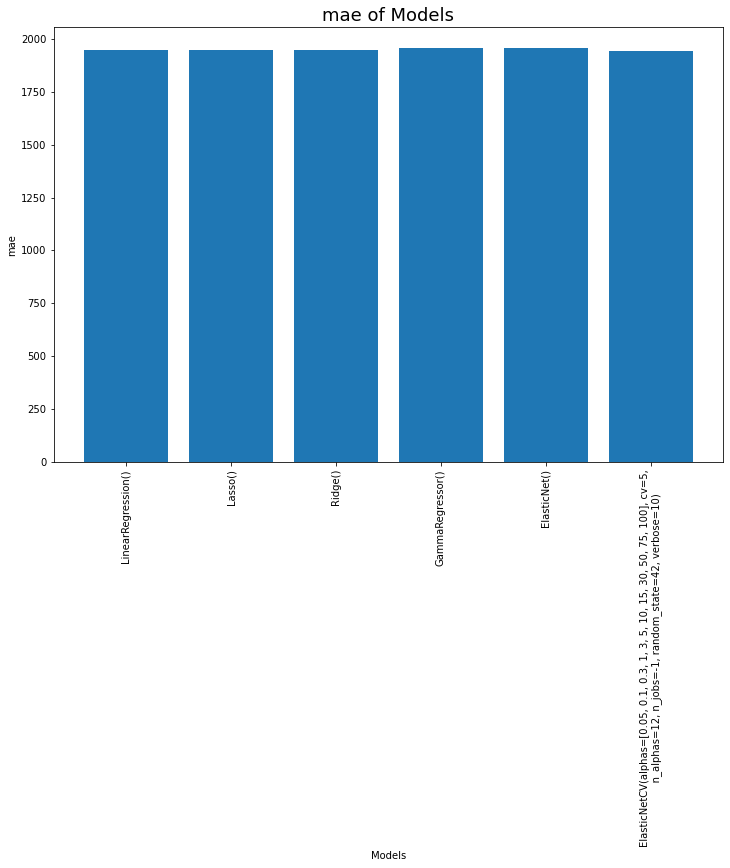

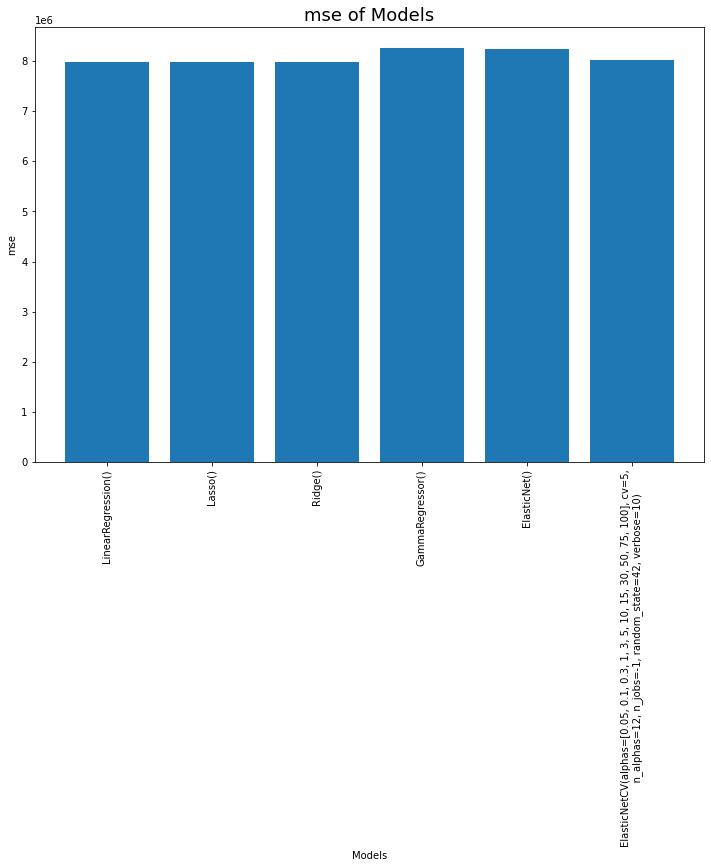

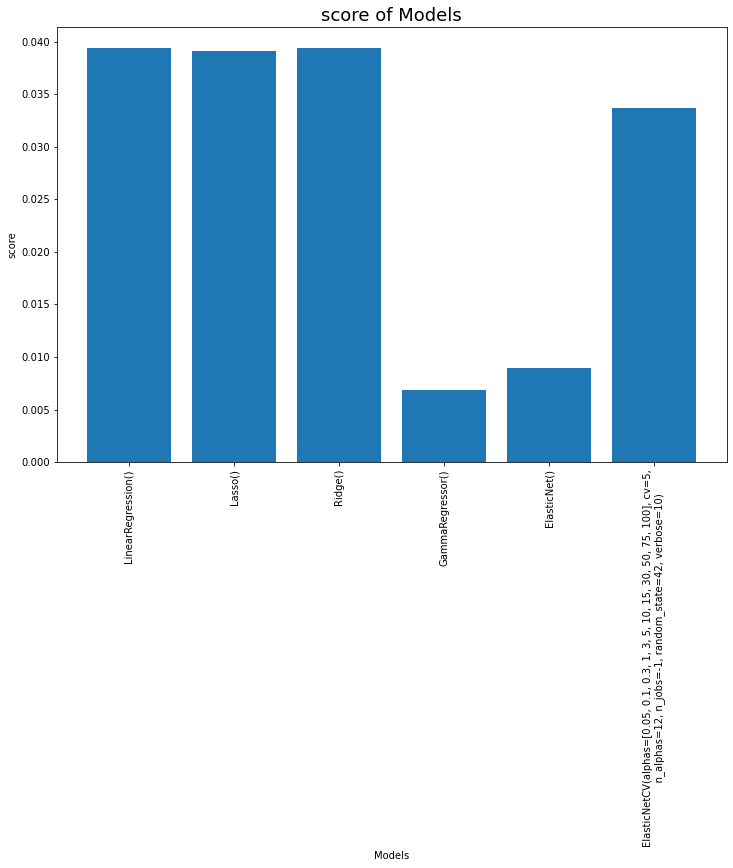

In [25]:
#And the final plots
#Cont

for model, metric in zip(cont_model_metrics, metrics):
    barplot_metrics(model, metric)


Above we see the plots for the continuous models' MAEs, MSEs, and $R^{2}$ scores. Looking at the MAEs, they are almost indistinguishable in performance, all in the mid 1900s. Scrolling down to the MSEs it is clear that the GammaRegressor and ElasticNet performed worse than the other models performing roughly the same, including the ElasticNetCV.

Major differences can be seen in the $R^{2}$ score where Ridge and LinearRegression have the highest $R^{2}$ score, explaining more variability in the data than the others. However, none of them perform very well, especially when we consider them as a group against the models utilizing all features via one-hot encoding. 

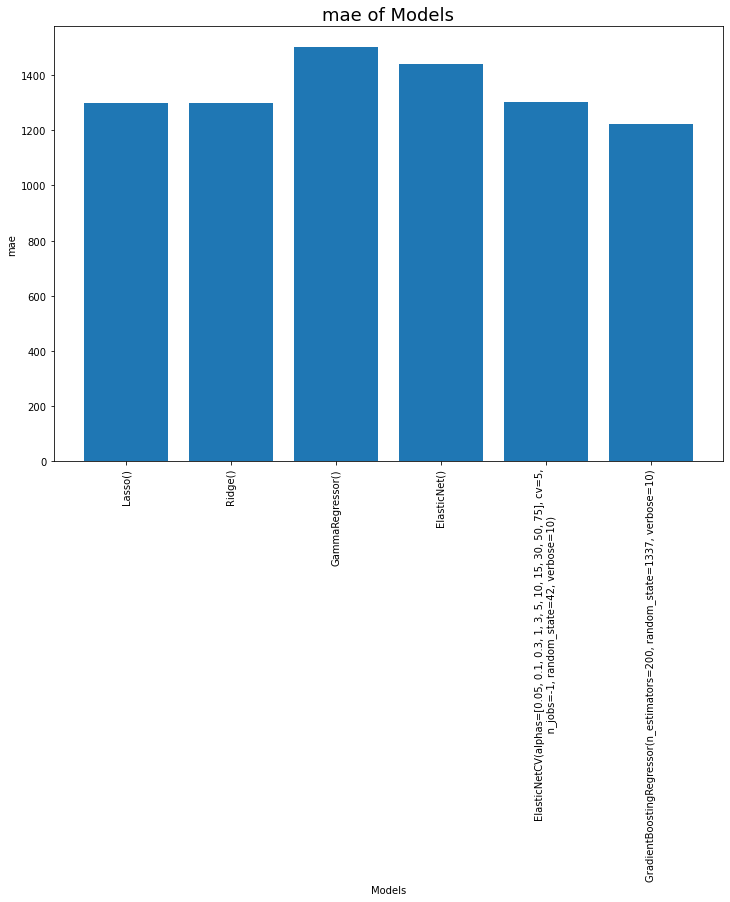

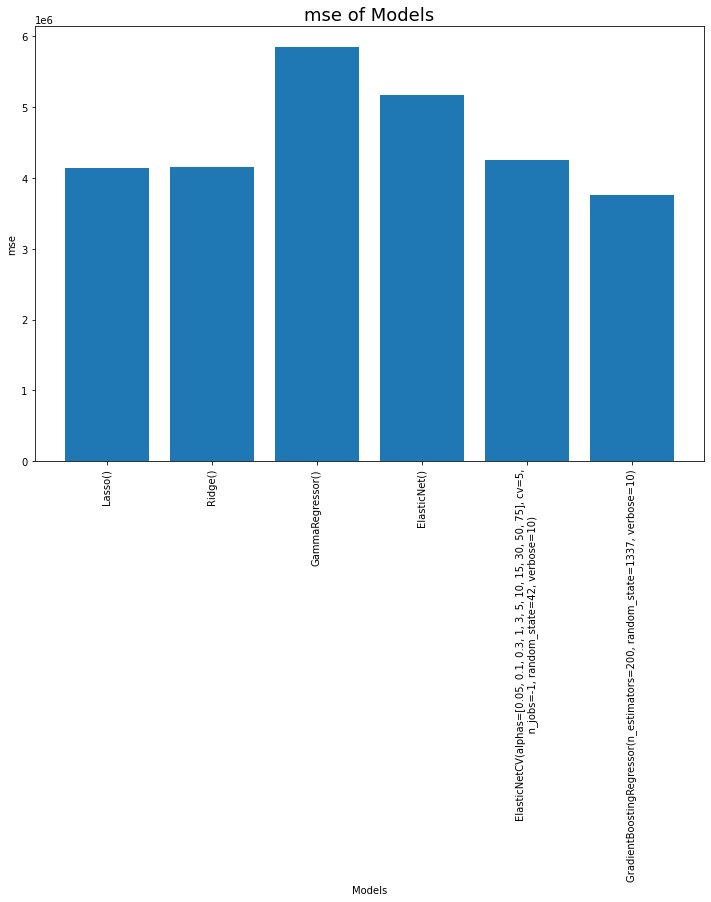

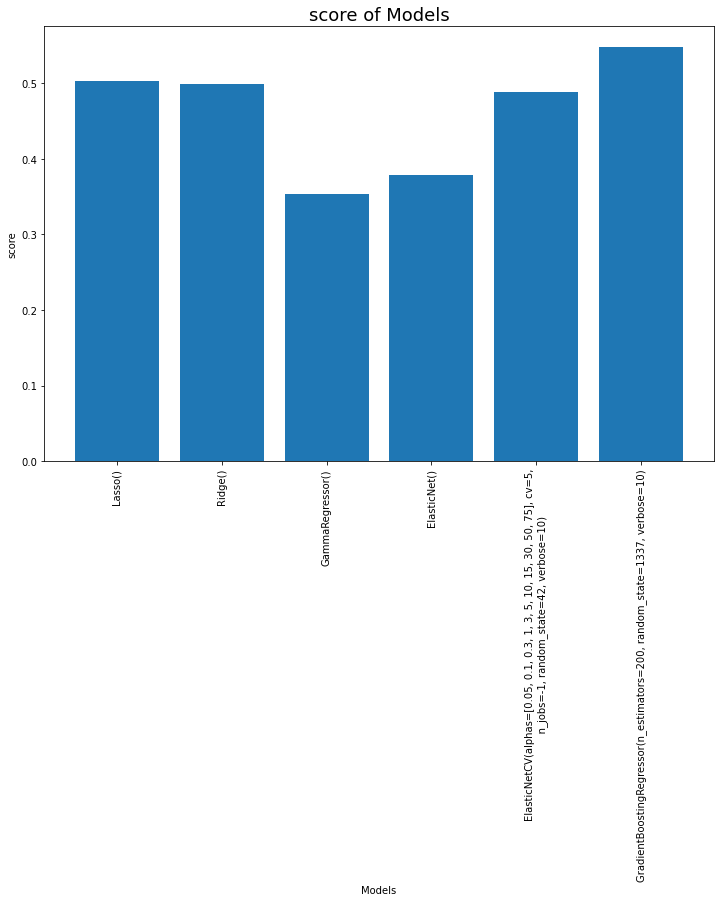

In [26]:
#Full
for model, metric in zip(full_model_metrics, metrics):   
    barplot_metrics(model, metric)
    
#Bam!!


Now that we have a visual for both sets of models, one thing is immediately clear: the full models outclass the continuous variable models. The worst peforming model, the GammaRegressor, outperforms the best performing continuous model. 

Of these models, we can spot that the GradientBoostingRegressor has the lowest MAE and the highest $R^{2}$. So in terms of explanatory power, this model is the best. 

Conclusion + Recap

The aim of this project was to predict claims loss severity using the data provided to us from Allstate through Kaggle. And we wanted to compare various linear regression models and contrast them with a gradient boosting regression model. 

To summarize the project, we: 

* Inspected the data and saw that there are 116 categorical features and 14 continuous features, no missing data points
    
* Explored the data and concluded that: 
    
    + there were no perfect multicolinearities amongst the continuous features, though a few pairs were close,

    + the target feature 'loss' follows a gamma distribution, and
        
    + most of the categorical features are binary and favored one option or the other
        
* Built a variety of linear regression models, including regularized models, using just the continuous variables
    
* Efficiently implemented a for loop to fit models to training data, predict using the test sets, and calculate 
    performance metrics
    
* Used relevant performance metrics to determine which models performed best
    
* Visualized feature importances to understand which features had more impact on performance 
    
* Transformed categorical features via one-hot encoding to perform modelling with the full set of features
    
* Built a new set of linear regression models as well as a gradient boosting regressor
    
* Repeated the fit and predict procedure for the models using the full set of features
    
* Evaluated, compared, and visualized results
    
* Concluded that the gradient boosting regressor is the best model in all three of our metrics, in particular, the mean       absolute error
    

   
If we had to select any of these models to put into production, we would select the gradient boosting regressor. Thankfully we do not have to!


Improvements for Next Time


While this project was a success, there are improvements that we can make to the process that would yield better results.

Some changes include, but are not limited to:
* Connecting to a cloud provider such as Google Cloud Platform to take advantage of their resources for speed
* Using more sophisticated techniques to explore the data and examine other relationships, for example principle component   analysis
* Consider feature interactions during the model building process
* Using sklearn's machine learning pipeline framework to perform more advanced preprocessing
* Testing more models using GridSearchCV and/or cross_val_score leveraging the speed from a cloud provider to gain more certainty on the performance of models
* Discuss and implement more advanced gradient boosting techniques such as XGBoost, LightGBM, and HistGradientBoostingRegressor
* Provide better visualizations of model diagnostics to aid in selecting the final model


Sources:

https://www.kaggle.com/c/allstate-claims-severity - Kaggle, Allstate Claims Severity

https://live-casact.pantheonsite.io/sites/default/files/2021-01/05-Goldburd-Khare-Tevet.pdf - CAS Monograph Series Number 5 Second Edition

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html - sklearn Linear Regression

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html - sklearn LASSO

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html - sklearn Ridge

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.GammaRegressor.html - sklearn Gamma Regressor

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html - sklearn Elastic Net

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html - sklearn Elastic Net CV

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html - sklearn Gradient Boosting Regressor

https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/ - machinelearningmastery A Gentle Introduction to the Gradient Boosting Algorithm

https://www.youtube.com/playlist?list=PLblh5JKOoLUJjeXUvUE0maghNuY2_5fY6 - Statquest with Josh Starmer Youtube Playlist Gradient Boost

https://statweb.stanford.edu/~jhf/ftp/trebst.pdf - Friedman - A Greedy Function Approximation: A Gradient Boosting Machine

https://en.wikipedia.org/wiki/Gradient_boosting - Wikipedia Gradient Boosting 

https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net - Datacamp Ridge Lasso Elastic Net

